In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [3]:
# config.py
from dotenv import load_dotenv

load_dotenv()

class Config:
    
    DETECTION_MODEL_PATH = 'C:/Users/DELL/Desktop/ctrlS nagpur/gpu-debug-main/train/weights/best.pt'
    # Processing Configuration
    MAX_RETRIES = 3
    PROCESSING_TIMEOUT = 3600 # 1 hour in seconds
    FRAMES_OUTPUT_DIR = 'frames'

    # Modified tracking parameters
    TRACKING_THRESHOLD = 0.8  # Increased from 0.5
    MAX_AGE = 45  # Increased from 30
    MIN_MA = 4   # Increased from 3

In [4]:
#kalman_track.py
from scipy.optimize import linear_sum_assignment
import scipy.linalg
import numpy as np
import os
import cv2
import time

np.random.seed(123)
# np.set_printoptions(suppress=True)


class KalmanFilter(object):
    """
    The 8-dimensional state space
    x, y, a, h, vx, vy, va, vh
    """
    count = 0
    def __init__(self, measurement):
        ndim, dt = 4, 1
        self.age = 0 # counter for no. of frame predicted
        self.hits = 0 # counter for no. of frame updated
        self.time_since_update = 0
        self.measurement_association = 0
        self.id = KalmanFilter.count
        KalmanFilter.count += 1
        self._prev_mean = None  # Store previous mean for smoothing

        self._motion_mat = np.eye(2*ndim, 2*ndim)
        for i in range(ndim):
            self._motion_mat[i, ndim+i] = dt

        self._transform_mat = np.eye(ndim, 2*ndim)

        # Observation and Motion uncertainty are chosen relative to the
        # current state estimate. These weights control the amount of
        # uncertainty in the model.
        self._std_weight_position = 1. / 20
        self._std_weight_velocity = 1. / 160

        # The mean vector(8 dimensional) and covariance matrix(8x8 dimensional)
        # of the new track. Unobserved velocities are initialized to 0.

        mean_pos = measurement
        mean_vel = np.zeros_like(mean_pos)

        self.mean = np.r_[mean_pos, mean_vel]
        self._prev_mean = self.mean.copy()  # Initialize previous mean

        # print('Initial mean : {}'.format(self.mean))
        # print('*'*50)

        std = [self._std_weight_position * measurement[3],
               self._std_weight_position * measurement[3],
               1e-2,
               self._std_weight_position * measurement[3],
               self._std_weight_velocity * measurement[3],
               self._std_weight_velocity * measurement[3],
               1e-5,
               self._std_weight_velocity * measurement[3]]

        self.covariance = np.diag(np.square(std))

        # print('Initial Covariance : {}'.format(self.covariance))
        # print('*'*50)

    def predict(self):
        """
        Run the Kalman Filter Prediction step
        Return:
            The mean and covariance matrix of the predicted state.
            Unobserved velocities are initialized to 0 mean.
        """
        self.age += 1
        if self.time_since_update > 0:
            self.measurement_association = 0

        self.time_since_update += 1

        std_pos = [self._std_weight_position * self.mean[3],
                   self._std_weight_position * self.mean[3],
                   1e-2,
                   self._std_weight_position * self.mean[3]]

        std_vel = [self._std_weight_velocity * self.mean[3],
                   self._std_weight_velocity * self.mean[3],
                   1e-5,
                   self._std_weight_velocity * self.mean[3]]

        motion_cov = np.diag(np.square(np.r_[std_pos, std_vel]))

        # print('Process Covariance(Error) : {}'.format(motion_cov))
        # print('*'*50)

        # x^(k+1) = F.x^k
        self.mean = np.dot(self._motion_mat, self.mean)
        
        # Add motion smoothing
        if self.age > 2 and self._prev_mean is not None:
            # Smooth velocity estimates
            self.mean[4:] = self.mean[4:] * 0.9 + self._prev_mean[4:] * 0.1
        
        self._prev_mean = self.mean.copy()
        
        # print('Predicted Mean : {}'.format(self.mean))
        # print('*'*50)
        # P^k = F.P^(k-1).Ft + Q
        self.covariance = np.linalg.multi_dot((self._motion_mat, self.covariance, self._motion_mat.T)) \
                            + motion_cov
        # print('Predicted Covariance : {}'.format(self.covariance))
        # print('*'*50)

        return np.dot(self._transform_mat, self.mean)

    def project(self):
        """
        Project state distribution to measurement state.
        Return: (ndarray, ndarray)
            The projected mean and covariance matrix of the given state estimate.
        """
        std = [self._std_weight_position * self.mean[3],
               self._std_weight_position * self.mean[3],
               1e-1,
               self._std_weight_position * self.mean[3]]

        measurement_cov = np.diag(np.square(std))

        # print('Measurement Error : {}'.format(measurement_cov))
        # print('*'*50)

        projected_mean = np.dot(self._transform_mat, self.mean)
        projected_cov = np.linalg.multi_dot((self._transform_mat, self.covariance, self._transform_mat.T)) \
                            + measurement_cov

        # print('Projected Mean : {}'.format(projected_mean))
        # print('*'*50)
        # print('Projected Covariance : {}'.format(projected_cov))
        # print('*'*50)

        return projected_mean, projected_cov

    def update(self, measurement):
        """
        Run KalmanFilter correction step.
        Returns:
            measurement-corrected state distribution.
        """
        self.time_since_update = 0
        self.hits += 1
        self.measurement_association += 1

        projected_mean, projected_cov = self.project()

        # (H.P.Ht + R).K' = P.Ht
        chol_factor, lower = scipy.linalg.cho_factor(projected_cov, lower=True, check_finite=False)

        # print('chol factor, lower : {}'.format(chol_factor))
        # print('*'*50)

        kalman_gain = scipy.linalg.cho_solve((chol_factor, lower),
                                np.dot(self.covariance, self._transform_mat.T).T, check_finite=False).T
        # print('Kalman Gain : {}'.format(kalman_gain))
        # print('*'*50)

        pos_correction = measurement - projected_mean

        # Add size consistency check
        current_size = self.mean[2] * self.mean[3]  # Current area
        new_size = measurement[2] * measurement[3]  # New measurement area
        
        # If sizes are drastically different, reduce the impact of the update
        size_ratio = min(current_size / new_size, new_size / current_size) if current_size > 0 and new_size > 0 else 0
        if size_ratio < 0.5:  # Less than 50% similarity
            # Scale down the Kalman gain to reduce impact of this measurement
            kalman_gain = kalman_gain * size_ratio

        # print('Position Correction : {}'.format(pos_correction))
        # print('*'*50)

        self.mean = self.mean + np.dot(pos_correction, kalman_gain.T)

        # print('Updated mean : {}'.format(self.mean))
        # print('*'*50)

        self.covariance = self.covariance - np.linalg.multi_dot((
                    kalman_gain, projected_cov, kalman_gain.T))

        # print('Updated Covariance : {}'.format(self.covariance))
        # print('*'*50)

    def get_updated_state(self):
        return np.dot(self._transform_mat, self.mean)

def iou(d_bbox, t_bbox):
    # iou = np.sqrt((np.square(d_bbox[0] - t_bbox[0]) + \
    #         np.square(d_bbox[1] - t_bbox[1])))
    d_bbox = d_bbox.copy()
    t_bbox = t_bbox.copy()
    
    d_bbox[2] *= d_bbox[3]
    d_bbox[:2] -= d_bbox[2:4] / 2.
    d_bbox[2:4] += d_bbox[:2]

    t_bbox[2] *= t_bbox[3]
    t_bbox[:2] -= t_bbox[2:4] / 2.
    t_bbox[2:4] += t_bbox[:2]

    xx1 = np.maximum(d_bbox[0], t_bbox[0])
    yy1 = np.maximum(d_bbox[1], t_bbox[1])
    xx2 = np.minimum(d_bbox[2], t_bbox[2])
    yy2 = np.minimum(d_bbox[3], t_bbox[3])

    intersection_width = np.maximum(0., xx2 - xx1)
    intersection_height = np.maximum(0., yy2 - yy1)

    intersection_area = intersection_width * intersection_height

    union_area = ((d_bbox[2] - d_bbox[0]) * (d_bbox[3] - d_bbox[1])) + \
                 ((t_bbox[2] - t_bbox[0]) * (t_bbox[3] - t_bbox[1])) - \
                 intersection_area

    iou = intersection_area / union_area
    # print(iou)
    # print()

    return iou

def associate_detections_to_trackers(d_bbox, t_bbox, iou_threshold=0.5):
    """
    Modified association function with higher IOU threshold
    """
    if len(t_bbox) == 0:
        return np.empty((0, 2), dtype=int), np.arange(len(d_bbox)), np.empty((0, 5), dtype=int)

    iou_matrix = np.zeros((len(d_bbox), len(t_bbox)), dtype=np.float32)

    d_bbox_iou = d_bbox.copy()
    t_bbox_iou = t_bbox.copy()

    for d_idx, det in enumerate(d_bbox_iou):
        for t_idx, trk in enumerate(t_bbox_iou):
            iou_matrix[d_idx, t_idx] = iou(det.copy(), trk.copy())

    # print('IOU Matrix : {}'.format(iou_matrix))
    # print('*'*50)

    if iou_matrix.shape[0] == 1:

        if not np.any(iou_matrix > iou_threshold):
            # iou_matrix = np.delete(iou_matrix, 0, axis=0)
            matched_indices = np.empty(shape=(0, 2))

        else:
            argmax = np.argmax(iou_matrix)
            matched_indices = np.array([[0, argmax]])

    elif iou_matrix.shape[1] == 1:

        if not np.any(iou_matrix > iou_threshold):
            matched_indices = np.empty(shape=(0, 2))

        else:
            argmax = np.argmax(iou_matrix)
            matched_indices = np.array([[argmax, 0]])

    elif min(iou_matrix.shape) > 0:

        cost_matrix = -1 * iou_matrix # if you are using eucidean distance then dont't multiply with -1
        x, y = linear_sum_assignment(cost_matrix)
        # print('Applied Hungarian Algo.')
        # print('*'*50)
        matched_indices = np.array(list(zip(x, y)))
    else:
        matched_indices = np.empty(shape=(0, 2))

    # print('Matched Indices : {}'.format(matched_indices))
    # print('*'*50)

    unmatched_detections = []
    # print('d_bbox: {}'.format(d_bbox))
    for d_idx, det in enumerate(d_bbox):
        if (d_idx not in matched_indices[:, 0]):
            unmatched_detections.append(d_idx)

    unmatched_trackers = []
    # print('t_bbox: {}'.format(t_bbox))
    for t_idx, trk in enumerate(t_bbox):
        if (t_idx not in matched_indices[:, 1]):
            unmatched_trackers.append(t_idx)

    # filter out matched with low IOU
    matches = []
    for m in matched_indices:
        if (iou_matrix[m[0], m[1]] < iou_threshold):
            unmatched_detections.append(m[0])
            unmatched_trackers.append(m[1])
        else:
            matches.append(m.reshape(1, 2))

    if len(matches) == 0:
        matches = np.empty((0, 2), dtype=int)
    else:
        matched_indices = np.concatenate(matches, axis=0)

    return matched_indices, np.array(unmatched_detections), np.array(unmatched_trackers)


class Sort(object):
    def __init__(self, max_age=60, min_ma=5):
        """
        Set key parameter for SORT
        """
        self.max_age = max_age # for how long we track the object when we stopped getting any measurement.
        self.min_ma = min_ma # new tracks are classified as tentative during first 3(min_ma) frame.
        #self.frame_count = 0 # frame count
        self.trackers = [] # trackers_list contains multiple tracked object in single frame.
        self.id_set = set()
        self.object_count = 0
        # Track object locations to prevent duplicates
        self.location_memory = {}

    def update(self, detected_bbox=np.empty((0, 5))):
        """
        This method must be called once for each frame even with empty detections (use np.empty((0,5)) for frames without detections).

        Param:
            numpy array of detections in the format [[x1,y1,x2,y2,score],[x3,y3,x4,y4,score],...]
        Return:
            The similar array, where the last column is the object ID.
        NOTE:
            The number of objects returned may differ from the number of detections provided.
        """
        #self.frame_count += 1
        # if we are tracking, get predicted locations from existing trackers.
        # Initialize a tracked_bbox array, make prediction for each trackers and get the predicted position.
        tracked_bbox = np.zeros((len(self.trackers), 5))

        # print('Predicted box')
        # print()

        to_del = [] # contains invalid tracker index
        for tr_idx, each_tracker in enumerate(tracked_bbox):
            pos = self.trackers[tr_idx].predict()
            # print(pos)
            # check for invalid position
            if np.any(np.isnan(pos)):
                to_del.append(tr_idx)
                continue
            each_tracker[:] = [pos[0], pos[1], pos[2], pos[3], 0]

        for invalid_tr_idx in reversed(to_del):
            self.trackers.pop(invalid_tr_idx)
            np.delete(tracked_bbox, invalid_tr_idx, axis=0)

        # Add spatial grid-based filtering to prevent double counting
        grid_size = 20  # Adjust based on your image size
        filtered_detections = []
        location_grid = {}
        
        # Filter detections to remove duplicates in similar locations
        if len(detected_bbox) > 0:
            for i, det in enumerate(detected_bbox):
                # Get grid cell for this detection
                grid_x = int(det[0] / grid_size)
                grid_y = int(det[1] / grid_size)
                grid_key = f"{grid_x}_{grid_y}"
                
                # Check if we already have a detection in this grid cell
                if grid_key not in location_grid:
                    location_grid[grid_key] = i
                    filtered_detections.append(det)
            
            # Use filtered detections instead of all detections
            if len(filtered_detections) > 0:
                filtered_detections = np.array(filtered_detections)
            else:
                filtered_detections = np.empty((0, 5))
            
            d_bbox = filtered_detections.copy()
        else:
            d_bbox = detected_bbox.copy()
            
        t_bbox = tracked_bbox.copy()

        # print('Detected bbox: {}'.format(d_bbox))
        # print('*'*50)
        # print('Tracked bbox : {}'.format(t_bbox))
        # print('*'*50)

        matched, unmatched_dets, unmatched_tracks = associate_detections_to_trackers(d_bbox, t_bbox)

        # print('Matched : {}'.format(matched))
        # print('*'*50)
        # print('Unmatched_dets : {}'.format(unmatched_dets))
        # print('*'*50)
        # print('Unmatched_tracks : {}'.format(unmatched_tracks))
        # print('*'*50)

        # update matched trackers with detection bbox i.e, measurement
        for m in matched:
            self.trackers[m[1]].update(d_bbox[m[0], :])

        # create and initialize new trackers for unmatched detections
        for i in unmatched_dets:
            # Check if this detection is in a similar location to an existing track
            # that we've seen before
            det_x, det_y = d_bbox[i, 0], d_bbox[i, 1]
            is_duplicate = False
            
            # Check for duplicate detections using spatial proximity
            for loc_key, track_info in self.location_memory.items():
                old_x, old_y = track_info['pos']
                # If the detection is close to a previously tracked object location
                if np.sqrt((det_x - old_x)**2 + (det_y - old_y)**2) < 30:
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                new_tracker = KalmanFilter(d_bbox[i, :])
                # Record this location to avoid duplicates
                grid_key = f"{int(det_x/10)}_{int(det_y/10)}"
                self.location_memory[grid_key] = {'pos': (det_x, det_y), 'age': 0}
                # print('Started Tracking...')
                self.trackers.append(new_tracker)

        # Age the location memory
        to_delete = []
        for key, info in self.location_memory.items():
            info['age'] += 1
            if info['age'] > 100:  # Remove old entries
                to_delete.append(key)
        
        for key in to_delete:
            del self.location_memory[key]

        # return only those tracker whose measurement association >= 3.
        # remove those tracker form tracker list whose time_since_update > max_age.
        ret = []
        i = len(self.trackers)
        #print(i)
        for each_tracker in reversed(self.trackers):

            d = each_tracker.get_updated_state()

            ret.append(np.concatenate((d, [each_tracker.id+1])).reshape(1, -1))

            if each_tracker.count not in self.id_set:
                if (each_tracker.measurement_association >= self.min_ma):
                    #ret.append(np.concatenate((d, [each_tracker.id+1])).reshape(1, -1))
                    self.id_set.add(each_tracker.count)

            if d[0] <= 100:
                i -= 1
                #self.id_set.remove(each_tracker.count)
                self.trackers.pop(i)
                # print('Deleted this track.')
                continue
            i -= 1
            # remove dead tracklet
            if (each_tracker.time_since_update > self.max_age):
                #self.id_set.remove(each_tracker.count)
                self.trackers.pop(i)

        if len(self.id_set):
            self.object_count = max(self.id_set)
            #print(self.id_set)

        if len(ret) > 0:
            return np.concatenate(ret), self.object_count

        return np.empty((0, 5)), self.object_count

In [5]:
#singlegpu_videoprocessor.py
'''import cv2
import os
import numpy as np
from datetime import datetime
from typing import Optional

from kalman_track import Sort
from logger import setup_logger
from config import Config

class ParallelVideoProcessor:
    def __init__(self, model_manager):
        self.logger = setup_logger('parallel_video_processor', 'parallel_video_processor.log')
        self.logger.info("Initializing ParallelVideoProcessor.")

        self.model_manager = model_manager
        
        self.MAX_AGE = Config.MAX_AGE
        self.MIN_MA = Config.MIN_MA
        self.TRACKING_THRESHOLD = Config.TRACKING_THRESHOLD
        
        # Create frames output directory
        self.frames_base_dir = Config.FRAMES_OUTPUT_DIR
        os.makedirs(self.frames_base_dir, exist_ok=True)
        
        # Track history for visualization
        self.track_history = {}

    def initialize_trackers(self):
        """Initialize separate trackers for each class"""
        trackers = {}
        for class_id in range(4):  # Assuming 4 classes (0-3)
            trackers[class_id] = Sort(self.MAX_AGE, self.MIN_MA)
        return trackers

    async def process_video(self, video_path: str, video_type: str):
        """Process video using available model instance"""
        try:
            # Get available model instance
            model_instance = await self.model_manager.get_available_model(video_type)
            self.logger.info(f"Got {video_type} model instance.")

            try:
                success = await self._process_hotspot_video(video_path, model_instance)
                return success
            finally:
                # Always release the model instance back to the pool
                await self.model_manager.release_model(model_instance)

        except Exception as e:
            self.logger.error(f"Error processing video: {str(e)}", exc_info=True)
            raise
    
    async def process_frame_hotspot(self, frame, model_instance, conf_threshold=0.65):
        """Process frame for hotspot detection using available model instance"""
        try:
            results = model_instance.model(frame, conf=conf_threshold)
            # Get bounding boxes for detected objects
            boxes = []
            detections = []
            
            for r in results:
                boxes_tensor = r.boxes.xyxy.cpu()   # Get boxes in xyxy format
                confs = r.boxes.conf.cpu()          # Get confidence scores
                cls = r.boxes.cls.cpu()             # Get class indices
                
                for box, conf, cl in zip(boxes_tensor, confs, cls):
                    if conf >= conf_threshold:
                        x1, y1, x2, y2 = map(int, box[:4])
                        cx = (x1 + x2) / 2.
                        cy = (y1 + y2) / 2.
                        ar = (x2 - x1) / (y2 - y1)
                        h = (y2 - y1)
                        # if cx <= 100 or cx >= 220:
                        #     continue
                        detections.append({
                            'bbox': [cx, cy, ar, h],
                            'confidence': float(conf),
                            'class': int(cl)
                        })
            
            return results, detections, boxes

        except Exception as e:
            self.logger.error(f"Error processing hotspot frame: {str(e)}", exc_info=True)
            raise

    async def _process_hotspot_video(self, video_path: str, model_instance):
        """Process hotspot video with given model instance"""
        self.logger.info(f"Starting hotspot detection for video_id")

        try:
            # Initialize separate trackers for each class
            self.logger.info("Initializing Kalman trackers for each class")
            trackers = self.initialize_trackers()
            
            # Create a history of positions for each tracked object
            if not hasattr(self, 'track_history'):
                self.track_history = {}
                
            # Dictionary to track objects by location
            location_tracker = {}
            
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise Exception(f"Failed to open video file: {video_path}")

            frame_count = 0
            frame_processed = 0
            tracked_objects = {class_id: {} for class_id in range(4)}  # Track objects per class
            processing_start = datetime.now()
            self.logger.info("Starting frame processing loop")

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_count += 1
                if frame_count % 5 == 0:  # Process every 10th frame
                    frame_processed += 1
                    current_frame_objects = set()

                    # Process frame
                    results, detections, _ = await self.process_frame_hotspot(
                        frame, model_instance
                    )
                    
                    # Apply spatial consistency filter to avoid duplicates
                    filtered_detections = []
                    for det in detections:
                        class_id = det['class']
                        centroid = (int(det['bbox'][0]), int(det['bbox'][1]))
                        # Create a grid-based key (10-pixel grid)
                        grid_key = f"{class_id}_{int(centroid[0]/10)}_{int(centroid[1]/10)}"
                        
                        # Skip if we've seen something in this area in recent frames
                        if grid_key in location_tracker and frame_count - location_tracker[grid_key] < 30:
                            continue
                            
                        # Otherwise track this location
                        location_tracker[grid_key] = frame_count
                        current_frame_objects.add(grid_key)
                        filtered_detections.append(det)
                    
                    # Organize detections by class
                    class_detections = {class_id: [] for class_id in range(4)}
                    for det in filtered_detections:
                        class_id = det['class']
                        bbox = det['bbox']
                        class_detections[class_id].append(bbox)

                    # Update trackers for each class
                    annotated_frame = results[0].plot()
                    
                    for class_id, dets in class_detections.items():
                        if len(dets) > 0:
                            dets_array = np.array(dets)
                            tracked_bbox, count = trackers[class_id].update(dets_array)
                        else:
                            tracked_bbox, count = trackers[class_id].update()

                        # Update tracked objects for this class
                        if len(tracked_bbox) > 0:
                            for track in tracked_bbox:
                                object_id = int(track[-1])
                                centroid = (int(track[0]), int(track[1]))
                                
                                if object_id not in tracked_objects[class_id]:
                                    tracked_objects[class_id][object_id] = {
                                        'frames_tracked': 0,
                                        'last_position': centroid,
                                        'class_id': class_id
                                    }
                                
                                tracked_objects[class_id][object_id]['frames_tracked'] += 1
                                tracked_objects[class_id][object_id]['last_position'] = centroid

                                # Create a unique key for this track
                                track_key = f"{class_id}_{object_id}"
                                
                                # Add current position to history
                                if track_key not in self.track_history:
                                    self.track_history[track_key] = []
                                
                                self.track_history[track_key].append(centroid)
                                
                                # Limit history length
                                if len(self.track_history[track_key]) > 30:
                                    self.track_history[track_key].pop(0)
                                
                                # Draw tracking info on frame
                                cv2.putText(annotated_frame, f"Class {class_id} ID {object_id}", 
                                            (centroid[0] - 10, centroid[1] - 10),
                                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                                cv2.circle(annotated_frame, centroid, 4, (0, 255, 0), -1)
                    
                    # Draw tracking line for each object
                    for track_key, history in self.track_history.items():
                        if len(history) > 1:
                            for i in range(1, len(history)):
                                cv2.line(annotated_frame, 
                                        history[i-1],
                                        history[i], 
                                        (0, 255, 0), 2)
                    
                    # Add debug info to each frame
                    debug_info = f"Frame: {frame_count} | Objects: {len(tracked_objects[0])},{len(tracked_objects[1])},{len(tracked_objects[2])},{len(tracked_objects[3])}"
                    cv2.putText(annotated_frame, debug_info, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                    # Save frame periodically (every 10 processed frames)
                    if frame_processed % 10 == 0:
                        frame_filename = f"frame_{frame_count}.jpg"
                        temp_frame_path = os.path.join(self.frames_base_dir, frame_filename)
                        
                        try:
                            cv2.imwrite(temp_frame_path, annotated_frame)
                            self.logger.debug(f"Frame saved: {temp_frame_path}")
                            
                        except Exception as e:
                            self.logger.error(f"Failed to save frame: {str(e)}")

            cap.release()
            self.logger.info(f"Video processing completed. Total frames: {frame_processed}")
            
            # Store final results
            processing_time = (datetime.now()-processing_start).total_seconds()
            total_tracked_objects = sum(len(objs) for objs in tracked_objects.values())
            
            final_results = {
                'total_frames': frame_processed,
                'unique_tracked_objects': total_tracked_objects,
                'objects_per_class': {
                    class_id: len(objs) 
                    for class_id, objs in tracked_objects.items()
                }
            }
            print(final_results)
            
            # Export detailed tracking data
            import json
            tracking_data = {
                'processing_time': processing_time,
                'total_frames': frame_processed,
                'tracked_objects': {}
            }

            for class_id, objects in tracked_objects.items():
                tracking_data['tracked_objects'][f'class_{class_id}'] = {}
                for obj_id, obj_data in objects.items():
                    tracking_data['tracked_objects'][f'class_{class_id}'][f'object_{obj_id}'] = {
                        'frames_tracked': obj_data['frames_tracked'],
                        'last_position': list(obj_data['last_position'])
                    }

            # Save to file
            with open('tracking_results.json', 'w') as f:
                json.dump(tracking_data, f, indent=2)
            
            self.logger.info(f"Processing completed in {processing_time:.2f} seconds. "
                        f"Found {total_tracked_objects} unique objects across all classes")
            
            return True

        except Exception as e:
            self.logger.error(f"Hotspot video processing failed: {str(e)}", exc_info=True)
            raise

    def cleanup(self):
        """Cleanup resources"""
        self.db_writer.shutdown()'''
import cv2
import os
import numpy as np
from datetime import datetime
from typing import Optional

from kalman_track import Sort
from logger import setup_logger
from config import Config

class ParallelVideoProcessor:
    def __init__(self, model_manager):
        self.logger = setup_logger('parallel_video_processor', 'parallel_video_processor.log')
        self.logger.info("Initializing ParallelVideoProcessor.")

        self.model_manager = model_manager
        
        self.MAX_AGE = Config.MAX_AGE
        self.MIN_MA = Config.MIN_MA
        self.TRACKING_THRESHOLD = Config.TRACKING_THRESHOLD
        
        # Create frames output directory
        self.frames_base_dir = Config.FRAMES_OUTPUT_DIR
        os.makedirs(self.frames_base_dir, exist_ok=True)
        
        # Track history for visualization
        self.track_history = {}

    def initialize_trackers(self):
        """Initialize separate trackers for each class"""
        trackers = {}
        for class_id in range(4):  # Assuming 4 classes (0-3)
            trackers[class_id] = Sort(self.MAX_AGE, self.MIN_MA)
        return trackers

    '''async def process_video(self, video_path: str, video_type: str, debug_mode=False):
        """Process video using available model instance"""
        try:
            # Get available model instance
            model_instance = await self.model_manager.get_available_model(video_type)
            self.logger.info(f"Got {video_type} model instance.")

            try:
                success = await self._process_hotspot_video(video_path, model_instance, debug_mode)
                return success
            finally:
                # Always release the model instance back to the pool
                await self.model_manager.release_model(model_instance)

        except Exception as e:
            self.logger.error(f"Error processing video: {str(e)}", exc_info=True)
            raise'''
    async def process_video(self, video_path: str, video_type: str, debug_mode=False):
        try:
            # Get available model instance
            model_instance = await self.model_manager.get_available_model(video_type)
            self.logger.info(f"Got {video_type} model instance.")

            try:
                success = await self._process_hotspot_video(video_path, model_instance, debug_mode)
                return success
            finally:
                # Always release the model instance back to the pool
                await self.model_manager.release_model(model_instance)

        except Exception as e:
            self.logger.error(f"Error processing video: {str(e)}", exc_info=True)
            raise
    
    async def process_frame_hotspot(self, frame, model_instance, conf_threshold=0.65):
        """Process frame for hotspot detection using available model instance"""
        try:
            results = model_instance.model(frame, conf=conf_threshold)
            # Get bounding boxes for detected objects
            boxes = []
            detections = []
            
            for r in results:
                boxes_tensor = r.boxes.xyxy.cpu()   # Get boxes in xyxy format
                confs = r.boxes.conf.cpu()          # Get confidence scores
                cls = r.boxes.cls.cpu()             # Get class indices
                
                for box, conf, cl in zip(boxes_tensor, confs, cls):
                    if conf >= conf_threshold:
                        x1, y1, x2, y2 = map(int, box[:4])
                        cx = (x1 + x2) / 2.
                        cy = (y1 + y2) / 2.
                        ar = (x2 - x1) / (y2 - y1)
                        h = (y2 - y1)
                        # if cx <= 100 or cx >= 220:
                        #     continue
                        detections.append({
                            'bbox': [cx, cy, ar, h],
                            'confidence': float(conf),
                            'class': int(cl)
                        })
            
            return results, detections, boxes

        except Exception as e:
            self.logger.error(f"Error processing hotspot frame: {str(e)}", exc_info=True)
            raise

    async def _process_hotspot_video(self, video_path: str, model_instance, debug_mode=False):
        """Process hotspot video with given model instance with debug mode"""
        self.logger.info(f"Starting hotspot detection for video_id")

        try:
            # Initialize separate trackers for each class
            self.logger.info("Initializing Kalman trackers for each class")
            trackers = self.initialize_trackers()
            
            # Create a history of positions for each tracked object
            if not hasattr(self, 'track_history'):
                self.track_history = {}
                
            # Dictionary to track objects by location
            location_tracker = {}
            
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise Exception(f"Failed to open video file: {video_path}")

            frame_count = 0
            frame_processed = 0
            tracked_objects = {class_id: {} for class_id in range(4)}  # Track objects per class
            processing_start = datetime.now()
            self.logger.info("Starting frame processing loop")
            
            # Create debug window if in debug mode
            if debug_mode:
                cv2.namedWindow("Debug View", cv2.WINDOW_NORMAL)
                cv2.resizeWindow("Debug View", 1280, 720)
                print("\nDEBUG MODE ENABLED")
                print("-------------------")
                print("Controls:")
                print("  - Press any key to advance to next frame")
                print("  - Press 'q' to quit")
                print("  - Press 's' to skip 50 frames")
                print("  - Press 'd' to toggle detailed debug info")
                print("-------------------\n")
                show_detailed = False

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_count += 1
                if frame_count % 5 == 0:  # Process every 5th frame
                    frame_processed += 1
                    current_frame_objects = set()

                    # Process frame
                    results, detections, _ = await self.process_frame_hotspot(
                        frame, model_instance
                    )
                    
                    # Debug info - initial detections
                    if debug_mode:
                        print(f"\n===== FRAME {frame_count} =====")
                        print(f"Raw detections: {len(detections)}")
                        if show_detailed:
                            for i, det in enumerate(detections):
                                print(f"  Detection {i}: Class {det['class']}, Pos ({int(det['bbox'][0])}, {int(det['bbox'][1])}), Conf {det['confidence']:.2f}")
                    
                    # Apply spatial consistency filter to avoid duplicates
                    filtered_detections = []
                    for det in detections:
                        class_id = det['class']
                        centroid = (int(det['bbox'][0]), int(det['bbox'][1]))
                        # Create a grid-based key (10-pixel grid)
                        grid_key = f"{class_id}_{int(centroid[0]/10)}_{int(centroid[1]/10)}"
                        
                        # Skip if we've seen something in this area in recent frames
                        if grid_key in location_tracker and frame_count - location_tracker[grid_key] < 30:
                            if debug_mode and show_detailed:
                                print(f"  Filtered detection at {centroid} (Class {class_id}) - seen recently")
                            continue
                            
                        # Otherwise track this location
                        location_tracker[grid_key] = frame_count
                        current_frame_objects.add(grid_key)
                        filtered_detections.append(det)
                    
                    # Debug info - filtered detections
                    if debug_mode:
                        print(f"Filtered detections: {len(filtered_detections)} (removed {len(detections)-len(filtered_detections)})")
                    
                    # Organize detections by class
                    class_detections = {class_id: [] for class_id in range(4)}
                    for det in filtered_detections:
                        class_id = det['class']
                        bbox = det['bbox']
                        class_detections[class_id].append(bbox)
                        
                    # Debug info - per class detections
                    if debug_mode:
                        for class_id, dets in class_detections.items():
                            print(f"Class {class_id} detections: {len(dets)}")

                    # Update trackers for each class
                    annotated_frame = results[0].plot()
                    
                    for class_id, dets in class_detections.items():
                        before_tracks = len([t for t in tracked_objects[class_id] if tracked_objects[class_id][t]['frames_tracked'] > 0])
                        
                        if len(dets) > 0:
                            dets_array = np.array(dets)
                            tracked_bbox, count = trackers[class_id].update(dets_array)
                        else:
                            tracked_bbox, count = trackers[class_id].update()

                        # Debug info - tracking details
                        if debug_mode:
                            after_tracks = len([t for t in tracked_objects[class_id] if tracked_objects[class_id][t]['frames_tracked'] > 0])
                            print(f"Class {class_id} tracks: {before_tracks} before, {len(tracked_bbox)} current, {after_tracks} after")

                        # Update tracked objects for this class
                        if len(tracked_bbox) > 0:
                            for track in tracked_bbox:
                                object_id = int(track[-1])
                                centroid = (int(track[0]), int(track[1]))
                                
                                is_new = object_id not in tracked_objects[class_id]
                                
                                if is_new:
                                    tracked_objects[class_id][object_id] = {
                                        'frames_tracked': 0,
                                        'last_position': centroid,
                                        'class_id': class_id
                                    }
                                    if debug_mode and show_detailed:
                                        print(f"  New track: Class {class_id}, ID {object_id}, Pos {centroid}")
                                
                                tracked_objects[class_id][object_id]['frames_tracked'] += 1
                                tracked_objects[class_id][object_id]['last_position'] = centroid

                                # Create a unique key for this track
                                track_key = f"{class_id}_{object_id}"
                                
                                # Add current position to history
                                if track_key not in self.track_history:
                                    self.track_history[track_key] = []
                                
                                self.track_history[track_key].append(centroid)
                                
                                # Limit history length
                                if len(self.track_history[track_key]) > 30:
                                    self.track_history[track_key].pop(0)
                                
                                # Draw tracking info on frame
                                text_color = (0, 255, 0)  # Green for existing tracks
                                if is_new:
                                    text_color = (0, 255, 255)  # Yellow for new tracks
                                    
                                cv2.putText(annotated_frame, f"Class {class_id} ID {object_id}", 
                                            (centroid[0] - 10, centroid[1] - 10),
                                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 2)
                                cv2.circle(annotated_frame, centroid, 4, text_color, -1)
                    
                    # Draw tracking line for each object
                    for track_key, history in self.track_history.items():
                        if len(history) > 1:
                            for i in range(1, len(history)):
                                cv2.line(annotated_frame, 
                                        history[i-1],
                                        history[i], 
                                        (0, 255, 0), 2)
                    
                    # Add debug info to each frame
                    active_tracks = sum(len([t for t in tracked_objects[c] if tracked_objects[c][t]['frames_tracked'] > 0]) 
                                      for c in range(4))
                    debug_info = f"Frame: {frame_count} | Active Tracks: {active_tracks}"
                    cv2.putText(annotated_frame, debug_info, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                    
                    # Add per-class counts
                    for class_id in range(4):
                        active = len([t for t in tracked_objects[class_id] if tracked_objects[class_id][t]['frames_tracked'] > 0])
                        cv2.putText(annotated_frame, f"Class {class_id}: {active}", 
                                    (10, 60 + 30*class_id), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                    # Save every processed frame in debug mode, otherwise every 10th
                    if debug_mode or frame_processed % 10 == 0:
                        frame_filename = f"frame_{frame_count}.jpg"
                        temp_frame_path = os.path.join(self.frames_base_dir, frame_filename)
                        
                        try:
                            cv2.imwrite(temp_frame_path, annotated_frame)
                            if debug_mode:
                                print(f"Frame saved: {temp_frame_path}")
                            else:
                                self.logger.debug(f"Frame saved: {temp_frame_path}")
                            
                        except Exception as e:
                            self.logger.error(f"Failed to save frame: {str(e)}")
                    
                    # Display frame in debug mode and wait for key press
                    if debug_mode:
                        cv2.imshow("Debug View", annotated_frame)
                        key = cv2.waitKey(0)  # Wait for key press
                        
                        if key == ord('q'):  # Press 'q' to quit
                            print("Quitting debug mode...")
                            break
                        elif key == ord('s'):  # Press 's' to skip frames
                            skip_to = frame_count + 50
                            print(f"Skipping to frame {skip_to}...")
                            while frame_count < skip_to:
                                ret, _ = cap.read()
                                if not ret:
                                    break
                                frame_count += 1
                        elif key == ord('d'):  # Press 'd' to toggle detailed debug
                            show_detailed = not show_detailed
                            print(f"Detailed debug info: {'ON' if show_detailed else 'OFF'}")

            cap.release()
            if debug_mode:
                cv2.destroyAllWindows()
                
            self.logger.info(f"Video processing completed. Total frames: {frame_processed}")
            
            # Store final results
            processing_time = (datetime.now()-processing_start).total_seconds()
            
            # Count only objects that were tracked for more than MIN_MA frames
            significant_objects = {
                class_id: {
                    obj_id: data for obj_id, data in objs.items() 
                    if data['frames_tracked'] >= self.MIN_MA
                }
                for class_id, objs in tracked_objects.items()
            }
            
            total_tracked_objects = sum(len(objs) for objs in significant_objects.values())
            
            final_results = {
                'total_frames': frame_processed,
                'unique_tracked_objects': total_tracked_objects,
                'objects_per_class': {
                    class_id: len(objs) 
                    for class_id, objs in significant_objects.items()
                }
            }
            print("\nFINAL RESULTS:")
            print(final_results)
            
            # Export detailed tracking data
            import json
            tracking_data = {
                'processing_time': processing_time,
                'total_frames': frame_processed,
                'tracked_objects': {}
            }

            for class_id, objects in significant_objects.items():
                tracking_data['tracked_objects'][f'class_{class_id}'] = {}
                for obj_id, obj_data in objects.items():
                    tracking_data['tracked_objects'][f'class_{class_id}'][f'object_{obj_id}'] = {
                        'frames_tracked': obj_data['frames_tracked'],
                        'last_position': list(obj_data['last_position'])
                    }

            # Save to file
            with open('tracking_results.json', 'w') as f:
                json.dump(tracking_data, f, indent=2)
            
            self.logger.info(f"Processing completed in {processing_time:.2f} seconds. "
                        f"Found {total_tracked_objects} unique objects across all classes")
            
            return True

        except Exception as e:
            self.logger.error(f"Hotspot video processing failed: {str(e)}", exc_info=True)
            raise

    def cleanup(self):
        """Cleanup resources"""
        if hasattr(self, 'db_writer'):
            self.db_writer.shutdown()

In [6]:
#debug_tracker
import asyncio
import sys
from main import ParallelProcessorWorker

async def debug_video(video_path, debug_mode=True):
    """Debug a video frame by frame"""
    print(f"Initializing debug mode for video: {video_path}")
    
    # Create processor worker with only 1 concurrent task for debugging
    processor_worker = ParallelProcessorWorker(num_concurrent_tasks=1)
    
    # Process the video with debug mode enabled
    await processor_worker.process_job({
        'video_path': video_path, 
        'video_type': 'hotspot',
        'debug_mode': debug_mode
    })
    
    print("Debug session completed.")

if __name__ == "__main__":
    # Get video path from command line or use default
    if len(sys.argv) > 1:
        video_path = sys.argv[1]
    else:
        video_path = "test.mp4"  # Default path
    
    print("Starting debug session...")
    print("=========================")
    print("Controls:")
    print("  - Press any key to advance to next frame")
    print("  - Press 'q' to quit")
    print("  - Press 's' to skip 50 frames")
    print("  - Press 'd' to toggle detailed debug info")
    print("=========================\n")
    
    try:
        # Run the debug session
        asyncio.run(debug_video(video_path))
    except KeyboardInterrupt:
        print("\nDebug session interrupted by user.")
    except Exception as e:
        print(f"Error in debug session: {str(e)}")

Starting debug session...
Controls:
  - Press any key to advance to next frame
  - Press 'q' to quit
  - Press 's' to skip 50 frames
  - Press 'd' to toggle detailed debug info

Error in debug session: asyncio.run() cannot be called from a running event loop


C:\Users\DELL\AppData\Local\Temp\ipykernel_41064\3839577401.py:44: RuntimeWarning: coroutine 'debug_video' was never awaited
  print(f"Error in debug session: {str(e)}")


In [7]:
# model_manager.py
import torch
from ultralytics import YOLO
from typing import Dict, Optional, List
import threading
import asyncio
import gc  # Add garbage collection

from logger import setup_logger
from config import Config

class ModelInstance:
    def __init__(self, model: YOLO, model_type: str):
        self.model = model
        self.model_type = model_type
        self.in_use = False
        self.lock = threading.Lock()
        # track memory usage for this instance
        # self.initial_memory = torch.cuda.memory_allocated()

class SingleGPUModelManager:
    def __init__(self, instances_per_type: int = 2, memory_threshold: float = 0.85):
        """
        Initialize model manager for single GPU
        Args:
            instances_per_type: Number of instances per model type to load
        """
        self.logger = setup_logger('gpu_model_manager', 'gpu_model_manager.log')
        self.logger.info("Initializing single_gpu_model_manager.")

        self.instances_per_type = instances_per_type
        self.memory_threshold = memory_threshold
        
        # Check if CUDA is available
        if torch.cuda.is_available():
            self.total_gpu_memory = torch.cuda.get_device_properties(0).total_memory
            self.logger.info(f"CUDA available. Total GPU memory: {self.total_gpu_memory/1e9:.2f} GB")
        else:
            self.logger.warning("CUDA not available, using CPU mode")
            self.total_gpu_memory = 0
        
        self.model_instances: Dict[str, List[ModelInstance]] = {
            'hotspot': []
        }
        self.model_locks = {
            'hotspot': threading.Lock()
        }
        self.initialize_models()
    
    def _check_memory_usage(self) -> float:
        """
        Check current GPU memory usage
        Returns:
            float: Fraction of GPU memory currently in use
        """
        if not torch.cuda.is_available():
            return 0.0
            
        allocated = torch.cuda.memory_allocated()
        return allocated / self.total_gpu_memory
    
    def initialize_models(self):
        """Initialize multiple instances of each model type on single GPU"""
        try:
            # Check if CUDA is available
            if torch.cuda.is_available():
                self.logger.info(f"Initializing {self.instances_per_type} instances per model type on GPU")
                
                # Initialize models with CUDA memory management
                with torch.cuda.device(0):
                    # Initialize hotspot models
                    for i in range(self.instances_per_type):
                        hotspot_model = YOLO(Config.DETECTION_MODEL_PATH)
                        hotspot_model.to('cuda')
                        self.model_instances['hotspot'].append(
                            ModelInstance(hotspot_model, 'hotspot')
                        )
                        self.logger.info(f"Detection Model: {i} initialized!")

                # Log GPU memory usage
                allocated = torch.cuda.memory_allocated(0)
                reserved = torch.cuda.memory_reserved(0)
                self.logger.info(f"GPU Memory: Allocated={allocated/1e9:.2f}GB, Reserved={reserved/1e9:.2f}GB")
            else:
                # CPU fallback
                self.logger.warning("CUDA not available. Initializing models on CPU")
                for i in range(self.instances_per_type):
                    hotspot_model = YOLO(Config.DETECTION_MODEL_PATH)
                    self.model_instances['hotspot'].append(
                        ModelInstance(hotspot_model, 'hotspot')
                    )
                    self.logger.info(f"Detection Model: {i} initialized on CPU!")
        
        except Exception as e:
            self.logger.error(f"Failed to initialize models: {str(e)}", exc_info=True)
            raise
    
    async def get_available_model(self, model_type: str) -> Optional[ModelInstance]:
        """Get an available model instance of the specified type"""
        while True:
            with self.model_locks[model_type]:
                for instance in self.model_instances[model_type]:
                    self.logger.info(f"Checking instance: {instance.model_type}")
                    with instance.lock:
                        if not instance.in_use:
                            instance.in_use = True
                            self.logger.info(f"Returning instance: {instance.model_type}")
                            return instance
            # If no instance is available, wait briefly before checking again
            await asyncio.sleep(1)
    
    def _clear_instance_memory(self, instance: ModelInstance):
        """
        Clear memory specifically associated with this model instance
        """
        try:
            # Clear stored intermediate results
            if hasattr(instance, 'intermediate_results'):
                instance.intermediate_results.clear()
            
            # Clear last computation if it exists
            if hasattr(instance, 'last_computation'):
                del instance.last_computation
                
            # Clear model gradients
            if hasattr(instance.model, 'zero_grad'):
                instance.model.zero_grad(set_to_none=True)  # More efficient than just zero_grad()
                
            # Remove any references to stored tensors
            for attr_name in dir(instance):
                attr = getattr(instance, attr_name)
                if isinstance(attr, torch.Tensor):
                    delattr(instance, attr_name)
                    
            # Force garbage collection for this instance
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.synchronize()  # Ensure CUDA operations are complete
                
        except Exception as e:
            self.logger.error(f"Error clearing instance memory: {str(e)}", exc_info=True)
    
    async def release_model(self, instance: ModelInstance):
        """
        Release a model instance back to the pool with targeted memory cleanup
        """
        try:
            with instance.lock:
                # Clear instance-specific memory
                self._clear_instance_memory(instance)
                
                # Check overall memory usage
                current_usage = self._check_memory_usage()
                self.logger.debug(f"Current GPU memory usage: {current_usage:.2%}")
                
                # If memory usage is above threshold, perform additional cleanup
                if current_usage > self.memory_threshold and torch.cuda.is_available():
                    self.logger.warning(
                        f"High memory usage detected ({current_usage:.2%}). "
                        "Performing additional cleanup."
                    )
                    torch.cuda.empty_cache()
                    
                    # Log memory after cleanup
                    new_usage = self._check_memory_usage()
                    self.logger.info(
                        f"Memory usage after cleanup: {new_usage:.2%} "
                        f"(freed {(current_usage - new_usage) * 100:.2f}%)"
                    )
                
                # Finally mark the instance as not in use
                instance.in_use = False
                self.logger.info(f"Released {instance.model_type} model instance")
                
        except Exception as e:
            self.logger.error(f"Error in release_model: {str(e)}", exc_info=True)
            raise

In [8]:
#gpu_services 
import asyncio
from main import ParallelProcessorWorker
from logger import setup_logger

class JobQueue:
    def __init__(self):
        self.queue = asyncio.Queue()
        self.processing = {} # Track processing jobs
        self.lock = asyncio.Lock()
    
    async def add_job(self, job: dict) -> bool:
        async with self.lock:
            if job['job_id'] in self.processing:
                return False
            self.processing[job['job_id']] = job
            await self.queue.put(job)
            return True
    
    async def mark_complete(self, job_id: int):
        async with self.lock:
            self.processing.pop(job_id, None)

class GPUService:
    def __init__(self, num_concurrent_tasks: int = 4):
        self.logger = setup_logger('job_parallel', 'job_parallel.log')
        self.processor_worker = ParallelProcessorWorker(num_concurrent_tasks=num_concurrent_tasks)
        self.job_queue = JobQueue()
        self.processing_task = None
        self.running = False
    
    async def start(self):
        """Start the processing loop"""
        self.running = True
        self.processing_task = asyncio.create_task(self.process_queue())
        self.logger.info("Started GPU API Service")
    
    async def stop(self):
        """Stop the processing loop and cleanup"""
        self.logger.info("Stopping GPU API Service")
        self.running = False
        if self.processing_task:
            self.processing_task.cancel()
            try:
                await self.processing_task
            except asyncio.CancelledError:
                pass
        
        # Wait for active tasks to complete
        if hasattr(self.processor_worker, 'active_tasks'):
            active_tasks = [task for task in self.processor_worker.active_tasks if not task.done()]
            if active_tasks:
                self.logger.info(f"Waiting for {len(active_tasks)} active tasks to complete")
                await asyncio.gather(*active_tasks, return_exceptions=True)
        self.logger.info("GPU API Service stopped")
    
    async def process_queue(self):
        """Main processing loop that handles queued jobs"""
        while True:
            try:
                try:
                    # Get next job from queue
                    # job = await self.job_queue.get()
                    job = await asyncio.wait_for(self.job_queue.queue.get(), timeout=1.0)
                except asyncio.TimeoutError:
                    continue
                # Start processing in parallel
                asyncio.create_task(self.process_job(job))
            except Exception as e:
                self.logger.error(f"Error in process_queue: {str(e)}")
                await asyncio.sleep(1)
    
    async def process_job(self, job: dict):
        """Process a single job"""
        try:
            self.logger.info(f"Processing job: {job['job_id']}")
            await self.processor_worker.process_job(job)
        except Exception as e:
            self.logger.error(f"Error processing job {job['job_id']}: {str(e)}")
        finally:
            await self.job_queue.mark_complete(job['job_id'])

    def get_status(self) -> dict:
        """Get current processing status"""
        return {
            "queued_jobs": self.job_queue.queue.qsize(),
            "processing_jobs": len(self.job_queue.processing),
            "active_tasks": len(self.processor_worker.active_tasks),
            "max_concurrent": self.processor_worker.num_concurrent_tasks
        }


In [9]:
#logger.py
import logging
import sys
from pathlib import Path

def setup_logger(name, log_file=None, level=logging.INFO):
    """Configure logger with custom formatting and multiple handlers"""
    # Create logs directory if it doesn't exist
    logs_dir = Path("logs")
    logs_dir.mkdir(exist_ok=True)

    # Create formatter
    formatter = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )

    # Create logger
    logger = logging.getLogger(name)
    logger.setLevel(level)

    # Clear any existing handlers
    logger.handlers = []

    # Console handler
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    # File handler
    if log_file:
        file_handler = logging.FileHandler(logs_dir / log_file)
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

    return logger

# Create separate loggers for different components

In [10]:
import asyncio
from typing import List

from logger import setup_logger
from model_manager import SingleGPUModelManager
from singlegpu_videoprocessor import ParallelVideoProcessor

class ParallelProcessorWorker:
    def __init__(self, num_concurrent_tasks: int = 2):
        self.num_concurrent_tasks = num_concurrent_tasks
        self.running = False
        self.logger = setup_logger('main', 'main.log')
        self.logger.info("Initializing main worker.")

        # Initialize GPU model manager with instances per type
        self.model_manager = SingleGPUModelManager(instances_per_type=num_concurrent_tasks)
        self.processor = ParallelVideoProcessor(self.model_manager)

        # Track active tasks
        self.active_tasks: List[asyncio.Task] = []
        self.semaphore = asyncio.Semaphore(num_concurrent_tasks)

    async def process_job(self, job: dict):
        """Process a single job with semaphore control and user verification"""
        async with self.semaphore: # Control concurrent processing
            try:
                video_path = job.get('video_path')
                video_type = job.get('video_type')
                debug_mode = job.get('debug_mode', False)
                
                try:
                    # Process video with optional debug mode
                    success = await self.processor.process_video(
                        video_path,
                        video_type,
                        debug_mode
                    )
                    self.logger.info(f"processing completed successfully: {success}")

                except Exception as e:
                    self.logger.error(f"Error processing job: {str(e)}", exc_info=True)

            except Exception as e:
                self.logger.error(f"Error in process_job: {str(e)}", exc_info=True)

if __name__ == "__main__":
    # For Jupyter notebook, you might need to use these lines instead:
    # import nest_asyncio
    # nest_asyncio.apply()
    # loop = asyncio.get_event_loop()
    # processor_worker = ParallelProcessorWorker(num_concurrent_tasks=2)
    # loop.run_until_complete(processor_worker.process_job({'video_path': 'test.mp4', 'video_type': 'hotspot'}))
    
    # For standard Python script:
    processor_worker = ParallelProcessorWorker(num_concurrent_tasks=2)
    asyncio.run(processor_worker.process_job({'video_path': 'C:/Users/DELL/Desktop/ctrlS nagpur/gpu-debug-main/test1.MP4', 'video_type': 'hotspot'}))

2025-03-03 19:07:58,449 - main - INFO - Initializing main worker.
2025-03-03 19:07:58,456 - gpu_model_manager - INFO - Initializing single_gpu_model_manager.
2025-03-03 19:07:59,342 - gpu_model_manager - INFO - Initializing 2 instances per model type on GPU
2025-03-03 19:07:59,775 - gpu_model_manager - INFO - Detection Model: 0 initialized!
2025-03-03 19:07:59,831 - gpu_model_manager - INFO - Detection Model: 1 initialized!
2025-03-03 19:07:59,831 - gpu_model_manager - INFO - GPU Memory: Allocated=0.02GB, Reserved=0.02GB
2025-03-03 19:07:59,842 - parallel_video_processor - INFO - Initializing ParallelVideoProcessor.


RuntimeError: asyncio.run() cannot be called from a running event loop

In [16]:
#main
'''
import asyncio
import nest_asyncio
from typing import List

from logger import setup_logger
from model_manager import SingleGPUModelManager
from singlegpu_videoprocessor import ParallelVideoProcessor

class ParallelProcessorWorker:
    def __init__(self, num_concurrent_tasks: int = 4):
        self.num_concurrent_tasks = num_concurrent_tasks
        self.running = False
        self.logger = setup_logger('main', 'main.log')
        self.logger.info("Initializing main worker.")

        # Initialize GPU model manager with instances per type
        self.model_manager = SingleGPUModelManager(instances_per_type=num_concurrent_tasks)
        self.processor = ParallelVideoProcessor(self.model_manager)

        # Track active tasks
        self.active_tasks: List[asyncio.Task] = []
        self.semaphore = asyncio.Semaphore(num_concurrent_tasks)

    async def process_job(self, job: dict):
        """Process a single job with semaphore control and user verification"""
        async with self.semaphore: # Control concurrent processing
            try:
                video_path = job.get('video_path')
                video_type = job.get('video_type')
                try:
                    # Process video
                    success = await self.processor.process_video(
                        video_path,
                        video_type
                    )
                    self.logger.info(f"processing completed successfully: {success}")

                except Exception as e:
                    self.logger.error(f"Error processing job: {str(e)}", exc_info=True)

            except Exception as e:
                self.logger.error(f"Error in process_job: {str(e)}", exc_info=True)

if __name__ == "__main__":
    # Add this line to make asyncio work in Jupyter
    nest_asyncio.apply()
    
    processor_worker = ParallelProcessorWorker(num_concurrent_tasks=4)
    
    # For Jupyter, use this instead of asyncio.run()
    loop = asyncio.get_event_loop()
    loop.run_until_complete(processor_worker.process_job({
        'video_path': 'C:/Users/DELL/Desktop/ctrlS nagpur/gpu-debug-main/test1.MP4', 
        'video_type': 'hotspot'
    }))'''

2025-03-03 16:08:17,654 - main - INFO - Initializing main worker.
2025-03-03 16:08:17,662 - gpu_model_manager - INFO - Initializing single_gpu_model_manager.
2025-03-03 16:08:17,662 - gpu_model_manager - INFO - Initializing 4 instances per model type on GPU
2025-03-03 16:08:17,789 - gpu_model_manager - INFO - Detection Model: 0 initialized!
2025-03-03 16:08:17,939 - gpu_model_manager - INFO - Detection Model: 1 initialized!
2025-03-03 16:08:18,085 - gpu_model_manager - INFO - Detection Model: 2 initialized!
2025-03-03 16:08:18,207 - gpu_model_manager - INFO - Detection Model: 3 initialized!
2025-03-03 16:08:18,207 - gpu_model_manager - INFO - GPU Memory: Allocated=0.14GB, Reserved=0.14GB
2025-03-03 16:08:18,207 - parallel_video_processor - INFO - Initializing ParallelVideoProcessor.
2025-03-03 16:08:18,207 - gpu_model_manager - INFO - Checking instance: hotspot
2025-03-03 16:08:18,207 - gpu_model_manager - INFO - Returning instance: hotspot
2025-03-03 16:08:18,207 - parallel_video_proc

In [38]:
import cv2
import numpy as np
import os
import json
from pathlib import Path
from datetime import datetime
import asyncio
import sys

# Import tracking components
from kalman_track import Sort
from model_manager import SingleGPUModelManager
from logger import setup_logger

logger = setup_logger('debug_tracker', 'debug_tracker.log')

class TrackerDebugger:
    def __init__(self, video_path, output_dir="debug_outputs", conf_threshold=0.5):
        """Initialize the tracker debugger with variable parameters"""
        self.video_path = video_path
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True, parents=True)
        self.conf_threshold = conf_threshold
        
        # Initialize model manager with 1 instance
        self.model_manager = SingleGPUModelManager(instances_per_type=1)
        
        # Parameters to test - you can adjust these ranges
        self.max_age_values = [10, 20, 30, 40, 50]
        self.min_ma_values = [1, 2, 3, 4, 5]
        
        # Tracking results
        self.results = {}
        
    async def get_model_instance(self):
        """Get an available model instance"""
        return await self.model_manager.get_available_model('hotspot')
        
    async def release_model_instance(self, instance):
        """Release the model instance"""
        await self.model_manager.release_model(instance)
        
    async def process_frame(self, frame, model_instance):
        """Process a single frame with the model"""
        results = model_instance.model(frame, conf=self.conf_threshold)
        
        # Get detections
        detections = []
        
        for r in results:
            boxes_tensor = r.boxes.xyxy.cpu()
            confs = r.boxes.conf.cpu()
            cls = r.boxes.cls.cpu()
            
            for box, conf, cl in zip(boxes_tensor, confs, cls):
                if conf >= self.conf_threshold:
                    x1, y1, x2, y2 = map(int, box[:4])
                    cx = (x1 + x2) / 2.
                    cy = (y1 + y2) / 2.
                    ar = (x2 - x1) / (y2 - y1)
                    h = (y2 - y1)
                    
                    detections.append({
                        'bbox': [cx, cy, ar, h],
                        'confidence': float(conf),
                        'class': int(cl)
                    })
        
        return results, detections
        
    def visualize_tracks(self, frame, tracked_objects, max_age, min_ma):
        """Visualize tracking results on frame"""
        annotated_frame = frame.copy()
        
        for class_id, objects in tracked_objects.items():
            for obj_id, obj_data in objects.items():
                centroid = obj_data['last_position']
                frames_tracked = obj_data['frames_tracked']
                
                # Draw ID and class
                cv2.putText(
                    annotated_frame, 
                    f"C{class_id}-ID{obj_id} ({frames_tracked})", 
                    (centroid[0] - 10, centroid[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
                )
                
                # Draw circle at centroid
                cv2.circle(annotated_frame, centroid, 4, (0, 255, 0), -1)
        
        # Add parameter info to frame
        cv2.putText(
            annotated_frame,
            f"MAX_AGE: {max_age}, MIN_MA: {min_ma}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
        )
        
        return annotated_frame
        
    async def test_parameters(self):
        """Test different combinations of tracking parameters"""
        cap = cv2.VideoCapture(self.video_path)
        if not cap.isOpened():
            raise Exception(f"Failed to open video: {self.video_path}")
            
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        logger.info(f"Processing video with {total_frames} frames at {fps} FPS")
        print(f"Processing video with {total_frames} frames at {fps} FPS")
        
        # Get model instance
        model_instance = await self.get_model_instance()
        
        try:
            # Test each parameter combination
            for max_age in self.max_age_values:
                for min_ma in self.min_ma_values:
                    param_key = f"max_age_{max_age}_min_ma_{min_ma}"
                    output_video_path = self.output_dir / f"{param_key}.mp4"
                    
                    logger.info(f"Testing MAX_AGE={max_age}, MIN_MA={min_ma}")
                    print(f"Testing MAX_AGE={max_age}, MIN_MA={min_ma}")
                    
                    # Initialize trackers for each class
                    trackers = {}
                    for class_id in range(4):
                        trackers[class_id] = Sort(max_age=max_age, min_ma=min_ma)
                    
                    # Reset video
                    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                    
                    # Setup video writer
                    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                    writer = cv2.VideoWriter(
                        str(output_video_path), 
                        fourcc, 
                        fps, 
                        (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
                    )
                    
                    # Process all frames
                    frame_count = 0
                    tracked_objects = {class_id: {} for class_id in range(4)}
                    track_history = []
                    
                    processing_start = datetime.now()
                    
                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break
                            
                        frame_count += 1
                        
                        # Process every 5th frame for speed
                        # In notebook, you might want to process more frames for better visualization
                        if frame_count % 5 == 0:
                            # Process frame
                            results, detections = await self.process_frame(frame, model_instance)
                            
                            # Organize detections by class
                            class_detections = {class_id: [] for class_id in range(4)}
                            for det in detections:
                                class_id = det['class']
                                bbox = det['bbox']
                                class_detections[class_id].append(bbox)
                                
                            # Update trackers for each class
                            frame_tracks = {
                                'frame': frame_count,
                                'tracks': {}
                            }
                            
                            for class_id, dets in class_detections.items():
                                if len(dets) > 0:
                                    dets_array = np.array(dets)
                                    tracked_bbox, count = trackers[class_id].update(dets_array)
                                else:
                                    tracked_bbox, count = trackers[class_id].update()
                                    
                                # Update tracked objects for this class
                                frame_tracks['tracks'][f'class_{class_id}'] = []
                                
                                if len(tracked_bbox) > 0:
                                    for track in tracked_bbox:
                                        object_id = int(track[-1])
                                        centroid = (int(track[0]), int(track[1]))
                                        
                                        if object_id not in tracked_objects[class_id]:
                                            tracked_objects[class_id][object_id] = {
                                                'frames_tracked': 0,
                                                'last_position': centroid,
                                                'class_id': class_id
                                            }
                                        
                                        tracked_objects[class_id][object_id]['frames_tracked'] += 1
                                        tracked_objects[class_id][object_id]['last_position'] = centroid
                                        
                                        frame_tracks['tracks'][f'class_{class_id}'].append({
                                            'id': object_id,
                                            'position': centroid,
                                            'frames_tracked': tracked_objects[class_id][object_id]['frames_tracked']
                                        })
                            
                            track_history.append(frame_tracks)
                            
                            # Visualize and save frame
                            annotated_frame = self.visualize_tracks(frame, tracked_objects, max_age, min_ma)
                            writer.write(annotated_frame)
                            
                            # Display progress
                            if frame_count % 100 == 0:
                                logger.info(f"Processed {frame_count}/{total_frames} frames")
                                print(f"Processed {frame_count}/{total_frames} frames")
                        else:
                            # Just write the original frame
                            writer.write(frame)
                    
                    writer.release()
                    
                    # Calculate metrics
                    processing_time = (datetime.now() - processing_start).total_seconds()
                    total_tracked_objects = sum(len(objs) for objs in tracked_objects.values())
                    
                    # Track stability - higher is better
                    # We want objects that are tracked consistently over many frames
                    avg_track_length = 0
                    if total_tracked_objects > 0:
                        total_frames_tracked = sum(
                            obj['frames_tracked'] 
                            for class_objs in tracked_objects.values() 
                            for obj in class_objs.values()
                        )
                        avg_track_length = total_frames_tracked / total_tracked_objects
                    
                    self.results[param_key] = {
                        'max_age': max_age,
                        'min_ma': min_ma,
                        'total_frames': frame_count,
                        'total_tracked_objects': total_tracked_objects,
                        'avg_track_length': avg_track_length,
                        'processing_time': processing_time,
                        'objects_per_class': {
                            str(class_id): len(objs) 
                            for class_id, objs in tracked_objects.items()
                        }
                    }
            
            # Save results to JSON
            with open(self.output_dir / 'tracking_results.json', 'w') as f:
                json.dump(self.results, f, indent=2)
                
            # Find best parameters based on tracking stability
            best_params = max(self.results.items(), key=lambda x: x[1]['avg_track_length'])
            best_key, best_metrics = best_params
            
            logger.info(f"Best parameters: {best_key}")
            logger.info(f"Metrics: {best_metrics}")
            print(f"Best parameters: {best_key}")
            print(f"Metrics: {best_metrics}")
            
            return best_metrics
                
        finally:
            cap.release()
            # Release model instance
            await self.release_model_instance(model_instance)
            
    def analyze_results(self):
        """Analyze and print tracking results in a meaningful way"""
        if not self.results:
            logger.error("No results to analyze")
            print("No results to analyze")
            return
            
        # Sort by average track length (higher is better)
        sorted_results = sorted(
            self.results.items(), 
            key=lambda x: x[1]['avg_track_length'], 
            reverse=True
        )
        
        print("\n========== TRACKING PARAMETER RESULTS ==========")
        print(f"{'Parameters':<20} {'Avg Track Length':<20} {'Object Count':<15} {'Processing Time':<15}")
        print("-" * 70)
        
        for key, metrics in sorted_results:
            print(f"{key:<20} {metrics['avg_track_length']:<20.2f} {metrics['total_tracked_objects']:<15} {metrics['processing_time']:<15.2f}s")
            
        # Get the best parameters
        best_key, best_metrics = sorted_results[0]
        max_age = best_metrics['max_age']
        min_ma = best_metrics['min_ma']
        
        print("\n========== BEST PARAMETERS ==========")
        print(f"MAX_AGE: {max_age}")
        print(f"MIN_MA: {min_ma}")
        print(f"Average track length: {best_metrics['avg_track_length']:.2f} frames")
        print(f"Total tracked objects: {best_metrics['total_tracked_objects']}")
        print(f"Objects per class: {best_metrics['objects_per_class']}")
        
        # Update config suggestion
        config_path = Path("config.py")
        if config_path.exists():
            config_text = config_path.read_text()
            updated_config = config_text.replace(
                f"MAX_AGE = 30", # Assuming default is 30
                f"MAX_AGE = {max_age}"
            ).replace(
                f"MIN_MA = 3", # Assuming default is 3
                f"MIN_MA = {min_ma}"
            )
            
            update_path = Path(self.output_dir) / "updated_config.py"
            update_path.write_text(updated_config)
            
            print(f"\nUpdated config file generated at: {update_path}")
            print("Replace your current config.py with this file to use the optimized parameters.")
        
        return max_age, min_ma

# In notebook, you can run this directly - copy this to a notebook cell
async def run_debugger(video_path, output_dir="debug_outputs"):
    debugger = TrackerDebugger(video_path=video_path, output_dir=output_dir)
    await debugger.test_parameters()
    best_max_age, best_min_ma = debugger.analyze_results()
    return best_max_age, best_min_ma

# Example usage in notebook:
# video_path = "path/to/your/video.mp4"
# best_max_age, best_min_ma = await run_debugger(video_path)

In [ ]:
import asyncio

# Specify your video path here
video_path = "C:/Users/DELL/Desktop/ctrlS nagpur/gpu-debug-main/test1.MP4"  # Replace with your actual video path
output_dir = "C:/Users/DELL/Desktop/ctrlS nagpur/gpu-debug-main/test1out.MP4"  # Optional: change the output directory

# Run the tracking parameter debugger
best_max_age, best_min_ma = await run_debugger(video_path, output_dir)

2025-03-03 17:56:42,308 - gpu_model_manager - INFO - Initializing single_gpu_model_manager.
2025-03-03 17:56:42,309 - gpu_model_manager - INFO - Initializing 1 instances per model type on GPU
2025-03-03 17:56:42,460 - gpu_model_manager - INFO - Detection Model: 0 initialized!
2025-03-03 17:56:42,461 - gpu_model_manager - INFO - GPU Memory: Allocated=0.09GB, Reserved=0.09GB
2025-03-03 17:56:42,474 - debug_tracker - INFO - Processing video with 24919 frames at 29.97002997002997 FPS
Processing video with 24919 frames at 29.97002997002997 FPS
2025-03-03 17:56:42,474 - gpu_model_manager - INFO - Checking instance: hotspot
2025-03-03 17:56:42,474 - gpu_model_manager - INFO - Returning instance: hotspot
2025-03-03 17:56:42,474 - debug_tracker - INFO - Testing MAX_AGE=10, MIN_MA=1
Testing MAX_AGE=10, MIN_MA=1

0: 512x640 4 solar_tables, 68.4ms
Speed: 17.5ms preprocess, 68.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 4 solar_tables, 0.0ms
Speed: 1.3ms preproc

Task exception was never retrieved
future: <Task finished name='Task-8' coro=<main() done, defined at C:\Users\DELL\AppData\Local\Temp\ipykernel_33972\4137560995.py:370> exception=SystemExit(2)>
Traceback (most recent call last):
  File "c:\Users\DELL\anaconda3\Lib\argparse.py", line 1931, in parse_known_args
    namespace, args = self._parse_known_args(args, namespace)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DELL\anaconda3\Lib\argparse.py", line 2196, in _parse_known_args
    raise ArgumentError(None, _('the following arguments are required: %s') %
argparse.ArgumentError: the following arguments are required: --video

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_33972\4137560995.

0: 512x640 2 solar_tables, 143.8ms
Speed: 0.0ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 solar_tables, 47.7ms
Speed: 16.3ms preprocess, 47.7ms inference, 17.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 solar_tables, 65.6ms
Speed: 0.0ms preprocess, 65.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 solar_tables, 18.9ms
Speed: 2.0ms preprocess, 18.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)
2025-03-03 18:02:06,151 - debug_tracker - INFO - Processed 18800/24919 frames
Processed 18800/24919 frames

0: 512x640 2 solar_tables, 19.3ms
Speed: 3.2ms preprocess, 19.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 solar_tables, 20.8ms
Speed: 0.0ms preprocess, 20.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 solar_tables, 21.9ms
Speed: 0.0ms preprocess, 21.9ms inference, 0.6ms postprocess pe

In [11]:
import cv2
import numpy as np
import os
import json
from pathlib import Path
from datetime import datetime
import asyncio
import sys
import time
from IPython.display import clear_output, display
from ipywidgets import Image
import matplotlib.pyplot as plt

# Import tracking components
from kalman_track import Sort
from model_manager import SingleGPUModelManager
from logger import setup_logger

logger = setup_logger('debug_tracker', 'debug_tracker.log')

class TrackerDebugger:
    def __init__(self, video_path, output_dir="debug_outputs", conf_threshold=0.5, show_display=True, max_frames=None):
        """Initialize the tracker debugger with variable parameters"""
        self.video_path = video_path
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True, parents=True)
        self.conf_threshold = conf_threshold
        self.show_display = show_display
        self.max_frames = max_frames  # Option to limit frames for faster testing
        
        # Create subfolder for frame images
        self.frames_dir = self.output_dir / "frames"
        self.frames_dir.mkdir(exist_ok=True)
        
        # Initialize model manager with 1 instance
        self.model_manager = SingleGPUModelManager(instances_per_type=1)
        
        # Parameters to test - you can adjust these ranges
        self.max_age_values = [10, 20, 30, 40, 50]
        self.min_ma_values = [1, 2, 3, 4, 5]
        
        # Tracking results
        self.results = {}
        
        # Display window settings
        self.display_scale = 0.75  # Scale the display window
        
    async def get_model_instance(self):
        """Get an available model instance"""
        return await self.model_manager.get_available_model('hotspot')
        
    async def release_model_instance(self, instance):
        """Release the model instance"""
        await self.model_manager.release_model(instance)
        
    async def process_frame(self, frame, model_instance):
        """Process a single frame with the model"""
        results = model_instance.model(frame, conf=self.conf_threshold)
        
        # Get detections
        detections = []
        
        for r in results:
            boxes_tensor = r.boxes.xyxy.cpu()
            confs = r.boxes.conf.cpu()
            cls = r.boxes.cls.cpu()
            
            for box, conf, cl in zip(boxes_tensor, confs, cls):
                if conf >= self.conf_threshold:
                    x1, y1, x2, y2 = map(int, box[:4])
                    cx = (x1 + x2) / 2.
                    cy = (y1 + y2) / 2.
                    ar = (x2 - x1) / (y2 - y1)
                    h = (y2 - y1)
                    
                    detections.append({
                        'bbox': [cx, cy, ar, h],
                        'confidence': float(conf),
                        'class': int(cl)
                    })
        
        return results, detections
        
    def visualize_tracks(self, frame, tracked_objects, max_age, min_ma):
        """Visualize tracking results on frame"""
        annotated_frame = frame.copy()
        
        # Draw bounding boxes and IDs for each tracked object
        for class_id, objects in tracked_objects.items():
            color = self.get_color_for_class(class_id)
            
            for obj_id, obj_data in objects.items():
                centroid = obj_data['last_position']
                frames_tracked = obj_data['frames_tracked']
                
                # Draw circle at centroid
                cv2.circle(annotated_frame, centroid, 4, color, -1)
                
                # Draw ID and class
                label = f"C{class_id}-ID{obj_id} ({frames_tracked})"
                text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
                
                # Calculate text position
                text_x = centroid[0] - text_size[0] // 2
                text_y = centroid[1] - 10
                
                # Ensure text is within frame bounds
                text_x = max(5, min(text_x, frame.shape[1] - text_size[0] - 5))
                text_y = max(text_size[1] + 5, text_y)
                
                # Add background rectangle for text
                cv2.rectangle(
                    annotated_frame, 
                    (text_x - 2, text_y - text_size[1] - 2),
                    (text_x + text_size[0] + 2, text_y + 2),
                    (0, 0, 0), 
                    -1
                )
                
                # Draw text
                cv2.putText(
                    annotated_frame, 
                    label, 
                    (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
                )
        
        # Add parameter info to frame
        cv2.rectangle(
            annotated_frame,
            (5, 5),
            (250, 70),
            (0, 0, 0),
            -1
        )
        
        cv2.putText(
            annotated_frame,
            f"MAX_AGE: {max_age}, MIN_MA: {min_ma}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2
        )
        
        # Add timestamp and frame count
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        cv2.putText(
            annotated_frame,
            f"{current_time}",
            (10, 60),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1
        )
        
        return annotated_frame
    
    def get_color_for_class(self, class_id):
        """Get a distinct color for each class"""
        colors = [
            (0, 255, 0),    # Green for class 0
            (255, 0, 0),    # Blue for class 1
            (0, 0, 255),    # Red for class 2
            (255, 255, 0),  # Cyan for class 3
        ]
        return colors[class_id % len(colors)]
    
    def display_frame(self, frame, title="Tracking Output"):
        """Display a frame in a window"""
        # Resize for display
        h, w = frame.shape[:2]
        display_w = int(w * self.display_scale)
        display_h = int(h * self.display_scale)
        display_frame = cv2.resize(frame, (display_w, display_h))
        
        # Convert BGR to RGB for matplotlib
        display_frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        
        # Clear previous output
        clear_output(wait=True)
        
        # Display using matplotlib
        plt.figure(figsize=(12, 8))
        plt.imshow(display_frame_rgb)
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Small delay to allow for display
        time.sleep(0.01)
    
    def save_frame_image(self, frame, max_age, min_ma, frame_num):
        """Save frame as an image file"""
        filename = f"frame_{max_age}_{min_ma}_{frame_num:06d}.jpg"
        cv2.imwrite(str(self.frames_dir / filename), frame)
        
    async def test_parameters(self):
        """Test different combinations of tracking parameters"""
        cap = cv2.VideoCapture(self.video_path)
        if not cap.isOpened():
            raise Exception(f"Failed to open video: {self.video_path}")
            
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        logger.info(f"Processing video with {total_frames} frames at {fps} FPS, resolution: {width}x{height}")
        print(f"Processing video with {total_frames} frames at {fps} FPS, resolution: {width}x{height}")
        
        # Limit total frames if requested
        if self.max_frames and self.max_frames < total_frames:
            total_frames = self.max_frames
            print(f"Limiting processing to {total_frames} frames")
        
        # Get model instance
        model_instance = await self.get_model_instance()
        
        try:
            # Test each parameter combination
            for max_age in self.max_age_values:
                for min_ma in self.min_ma_values:
                    param_key = f"max_age_{max_age}_min_ma_{min_ma}"
                    output_video_path = self.output_dir / f"{param_key}.mp4"
                    
                    logger.info(f"Testing MAX_AGE={max_age}, MIN_MA={min_ma}")
                    print(f"Testing MAX_AGE={max_age}, MIN_MA={min_ma}")
                    
                    # Initialize trackers for each class
                    trackers = {}
                    for class_id in range(4):
                        trackers[class_id] = Sort(max_age=max_age, min_ma=min_ma)
                    
                    # Reset video
                    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                    
                    # Setup video writer
                    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                    writer = cv2.VideoWriter(
                        str(output_video_path), 
                        fourcc, 
                        fps, 
                        (width, height)
                    )
                    
                    # Process all frames
                    frame_count = 0
                    tracked_objects = {class_id: {} for class_id in range(4)}
                    processing_start = datetime.now()
                    
                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break
                            
                        frame_count += 1
                        
                        # Stop if we've reached max_frames
                        if self.max_frames and frame_count > self.max_frames:
                            break
                        
                        # Process every 5th frame for speed
                        # You can adjust this to process more or fewer frames
                        if frame_count % 5 == 0:
                            # Process frame
                            results, detections = await self.process_frame(frame, model_instance)
                            
                            # Organize detections by class
                            class_detections = {class_id: [] for class_id in range(4)}
                            for det in detections:
                                class_id = det['class']
                                bbox = det['bbox']
                                class_detections[class_id].append(bbox)
                                
                            # Update trackers for each class
                            for class_id, dets in class_detections.items():
                                if len(dets) > 0:
                                    dets_array = np.array(dets)
                                    tracked_bbox, count = trackers[class_id].update(dets_array)
                                else:
                                    tracked_bbox, count = trackers[class_id].update()
                                    
                                # Update tracked objects for this class
                                if len(tracked_bbox) > 0:
                                    for track in tracked_bbox:
                                        object_id = int(track[-1])
                                        centroid = (int(track[0]), int(track[1]))
                                        
                                        if object_id not in tracked_objects[class_id]:
                                            tracked_objects[class_id][object_id] = {
                                                'frames_tracked': 0,
                                                'last_position': centroid,
                                                'class_id': class_id
                                            }
                                        
                                        tracked_objects[class_id][object_id]['frames_tracked'] += 1
                                        tracked_objects[class_id][object_id]['last_position'] = centroid
                            
                            # Visualize and save frame
                            annotated_frame = self.visualize_tracks(frame, tracked_objects, max_age, min_ma)
                            
                            # Display frame if requested
                            if self.show_display and frame_count % 10 == 0:  # Update display every 10th processed frame
                                title = f"Tracking with MAX_AGE={max_age}, MIN_MA={min_ma} | Frame {frame_count}/{total_frames}"
                                self.display_frame(annotated_frame, title)
                            
                            # Save key frames as individual images
                            if frame_count % 30 == 0:  # Save every 30th processed frame as an image
                                self.save_frame_image(annotated_frame, max_age, min_ma, frame_count)
                            
                            # Write frame to video
                            writer.write(annotated_frame)
                            
                            # Display progress
                            if frame_count % 100 == 0:
                                logger.info(f"Processed {frame_count}/{total_frames} frames")
                                if not self.show_display:  # If not showing frames, print progress
                                    print(f"Processed {frame_count}/{total_frames} frames")
                        else:
                            # Just write the original frame to keep video complete
                            writer.write(frame)
                    
                    writer.release()
                    
                    # Calculate metrics
                    processing_time = (datetime.now() - processing_start).total_seconds()
                    total_tracked_objects = sum(len(objs) for objs in tracked_objects.values())
                    
                    # Track stability - higher is better
                    # We want objects that are tracked consistently over many frames
                    avg_track_length = 0
                    if total_tracked_objects > 0:
                        total_frames_tracked = sum(
                            obj['frames_tracked'] 
                            for class_objs in tracked_objects.values() 
                            for obj in class_objs.values()
                        )
                        avg_track_length = total_frames_tracked / total_tracked_objects
                    
                    self.results[param_key] = {
                        'max_age': max_age,
                        'min_ma': min_ma,
                        'total_frames': frame_count,
                        'total_tracked_objects': total_tracked_objects,
                        'avg_track_length': avg_track_length,
                        'processing_time': processing_time,
                        'objects_per_class': {
                            str(class_id): len(objs) 
                            for class_id, objs in tracked_objects.items()
                        }
                    }
            
            # Save results to JSON
            with open(self.output_dir / 'tracking_results.json', 'w') as f:
                json.dump(self.results, f, indent=2)
                
            # Find best parameters based on tracking stability
            best_params = max(self.results.items(), key=lambda x: x[1]['avg_track_length'])
            best_key, best_metrics = best_params
            
            logger.info(f"Best parameters: {best_key}")
            logger.info(f"Metrics: {best_metrics}")
            print(f"Best parameters: {best_key}")
            print(f"Metrics: {best_metrics}")
            
            return best_metrics
                
        finally:
            cap.release()
            # Release model instance
            await self.release_model_instance(model_instance)
            
    def analyze_results(self, visualize=True):
        """Analyze and print tracking results in a meaningful way"""
        if not self.results:
            logger.error("No results to analyze")
            print("No results to analyze")
            return
            
        # Sort by average track length (higher is better)
        sorted_results = sorted(
            self.results.items(), 
            key=lambda x: x[1]['avg_track_length'], 
            reverse=True
        )
        
        print("\n========== TRACKING PARAMETER RESULTS ==========")
        print(f"{'Parameters':<20} {'Avg Track Length':<20} {'Object Count':<15} {'Processing Time':<15}")
        print("-" * 70)
        
        for key, metrics in sorted_results:
            print(f"{key:<20} {metrics['avg_track_length']:<20.2f} {metrics['total_tracked_objects']:<15} {metrics['processing_time']:<15.2f}s")
            
        # Get the best parameters
        best_key, best_metrics = sorted_results[0]
        max_age = best_metrics['max_age']
        min_ma = best_metrics['min_ma']
        
        print("\n========== BEST PARAMETERS ==========")
        print(f"MAX_AGE: {max_age}")
        print(f"MIN_MA: {min_ma}")
        print(f"Average track length: {best_metrics['avg_track_length']:.2f} frames")
        print(f"Total tracked objects: {best_metrics['total_tracked_objects']}")
        print(f"Objects per class: {best_metrics['objects_per_class']}")
        
        # Visualize results if requested
        if visualize:
            self.visualize_results(sorted_results)
        
        # Update config suggestion
        config_path = Path("config.py")
        if config_path.exists():
            try:
                config_text = config_path.read_text()
                updated_config = config_text.replace(
                    f"MAX_AGE = 30", # Assuming default is 30
                    f"MAX_AGE = {max_age}"
                ).replace(
                    f"MIN_MA = 3", # Assuming default is 3
                    f"MIN_MA = {min_ma}"
                )
                
                update_path = Path(self.output_dir) / "updated_config.py"
                update_path.write_text(updated_config)
                
                print(f"\nUpdated config file generated at: {update_path}")
                print("Replace your current config.py with this file to use the optimized parameters.")
            except Exception as e:
                print(f"Error updating config: {e}")
        
        return max_age, min_ma
    
    def visualize_results(self, sorted_results):
        """Create visualization plots for the results"""
        # Extract data for plotting
        params = [key for key, _ in sorted_results]
        avg_track_lengths = [metrics['avg_track_length'] for _, metrics in sorted_results]
        object_counts = [metrics['total_tracked_objects'] for _, metrics in sorted_results]
        processing_times = [metrics['processing_time'] for _, metrics in sorted_results]
        
        # Create figure with multiple subplots
        fig, axs = plt.subplots(3, 1, figsize=(12, 15))
        
        # Plot average track length
        axs[0].bar(params, avg_track_lengths, color='skyblue')
        axs[0].set_title('Average Track Length by Parameter Configuration')
        axs[0].set_xlabel('Parameter Configuration')
        axs[0].set_ylabel('Average Track Length (frames)')
        axs[0].set_xticklabels(params, rotation=45, ha='right')
        axs[0].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Plot object counts
        axs[1].bar(params, object_counts, color='lightgreen')
        axs[1].set_title('Total Tracked Objects by Parameter Configuration')
        axs[1].set_xlabel('Parameter Configuration')
        axs[1].set_ylabel('Number of Objects')
        axs[1].set_xticklabels(params, rotation=45, ha='right')
        axs[1].grid(axis='y', linestyle='--', alpha=0.7)
        
        # Plot processing times
        axs[2].bar(params, processing_times, color='salmon')
        axs[2].set_title('Processing Time by Parameter Configuration')
        axs[2].set_xlabel('Parameter Configuration')
        axs[2].set_ylabel('Time (seconds)')
        axs[2].set_xticklabels(params, rotation=45, ha='right')
        axs[2].grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        
        # Save figure
        fig.savefig(str(self.output_dir / 'parameter_comparison.png'), dpi=300, bbox_inches='tight')
        
        # Display figure
        plt.show()
        
        # Create parameter heatmap for MAX_AGE and MIN_MA
        if len(self.max_age_values) > 1 and len(self.min_ma_values) > 1:
            # Create matrix for heatmap
            heatmap_data = np.zeros((len(self.min_ma_values), len(self.max_age_values)))
            
            for i, min_ma in enumerate(self.min_ma_values):
                for j, max_age in enumerate(self.max_age_values):
                    key = f"max_age_{max_age}_min_ma_{min_ma}"
                    if key in self.results:
                        heatmap_data[i, j] = self.results[key]['avg_track_length']
            
            # Plot heatmap
            plt.figure(figsize=(10, 8))
            plt.imshow(heatmap_data, cmap='viridis', interpolation='nearest')
            plt.colorbar(label='Average Track Length (frames)')
            plt.title('Parameter Optimization Heatmap')
            plt.xlabel('MAX_AGE')
            plt.ylabel('MIN_MA')
            plt.xticks(range(len(self.max_age_values)), self.max_age_values)
            plt.yticks(range(len(self.min_ma_values)), self.min_ma_values)
            
            # Add text annotations in each cell
            for i in range(len(self.min_ma_values)):
                for j in range(len(self.max_age_values)):
                    plt.text(j, i, f"{heatmap_data[i, j]:.2f}", 
                            ha="center", va="center", color="w" if heatmap_data[i, j] < np.max(heatmap_data)/1.5 else "black")
            
            plt.tight_layout()
            plt.savefig(str(self.output_dir / 'parameter_heatmap.png'), dpi=300, bbox_inches='tight')
            plt.show()

# Function to run the debugger from a Jupyter notebook
async def run_debugger(video_path, output_dir="debug_outputs", show_display=True, max_frames=None):
    """
    Run the tracking parameter debugger
    
    Args:
        video_path (str): Path to the video file
        output_dir (str): Directory to save outputs
        show_display (bool): Whether to show live visualization
        max_frames (int, optional): Maximum number of frames to process
        
    Returns:
        tuple: Best MAX_AGE and MIN_MA values
    """
    debugger = TrackerDebugger(
        video_path=video_path, 
        output_dir=output_dir,
        show_display=show_display,
        max_frames=max_frames
    )
    
    await debugger.test_parameters()
    best_max_age, best_min_ma = debugger.analyze_results()
    
    return best_max_age, best_min_ma

# Example usage in notebook:
# video_path = "path/to/your/video.mp4"
# best_max_age, best_min_ma = await run_debugger(video_path, max_frames=1000)

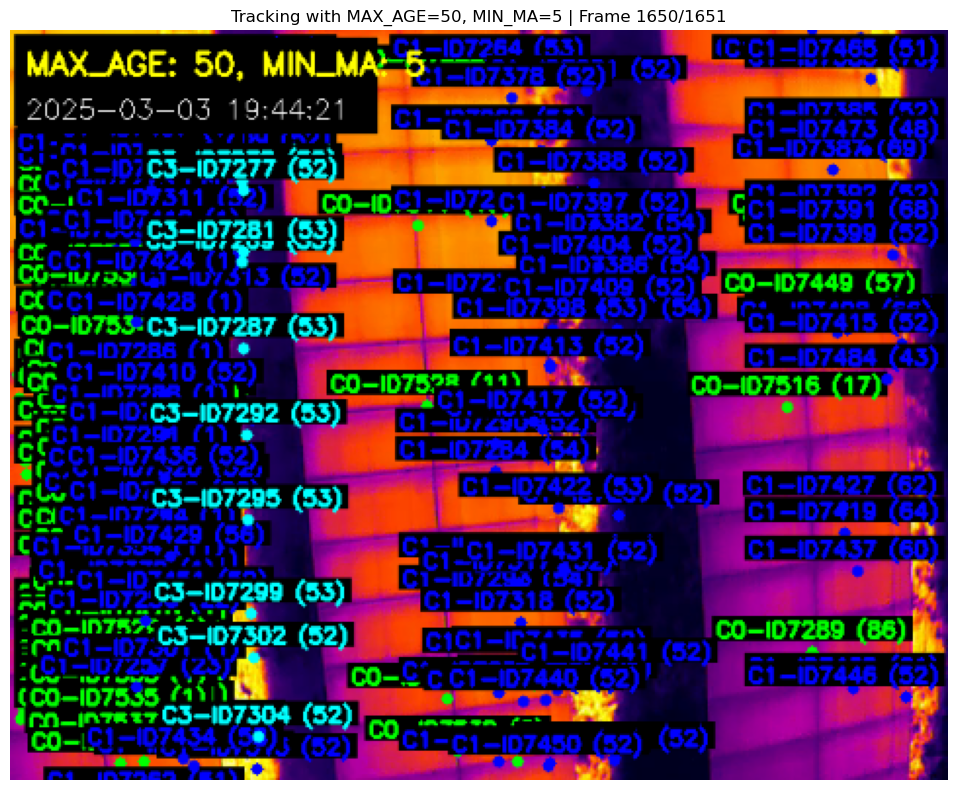

2025-03-03 19:44:21,638 - debug_tracker - INFO - Best parameters: max_age_50_min_ma_1
2025-03-03 19:44:21,639 - debug_tracker - INFO - Metrics: {'max_age': 50, 'min_ma': 1, 'total_frames': 1651, 'total_tracked_objects': 298, 'avg_track_length': 27.308724832214764, 'processing_time': 82.14579, 'objects_per_class': {'0': 160, '1': 126, '2': 0, '3': 12}}
Best parameters: max_age_50_min_ma_1
Metrics: {'max_age': 50, 'min_ma': 1, 'total_frames': 1651, 'total_tracked_objects': 298, 'avg_track_length': 27.308724832214764, 'processing_time': 82.14579, 'objects_per_class': {'0': 160, '1': 126, '2': 0, '3': 12}}
2025-03-03 19:44:21,639 - gpu_model_manager - INFO - Released hotspot model instance

========== TRACKING PARAMETER RESULTS ==========
Parameters           Avg Track Length     Object Count    Processing Time
----------------------------------------------------------------------
max_age_50_min_ma_1  27.31                298             82.15          s
max_age_50_min_ma_2  27.31         

C:\Users\DELL\AppData\Local\Temp\ipykernel_41064\1218490626.py:447: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(params, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_41064\1218490626.py:455: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(params, rotation=45, ha='right')
C:\Users\DELL\AppData\Local\Temp\ipykernel_41064\1218490626.py:463: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(params, rotation=45, ha='right')


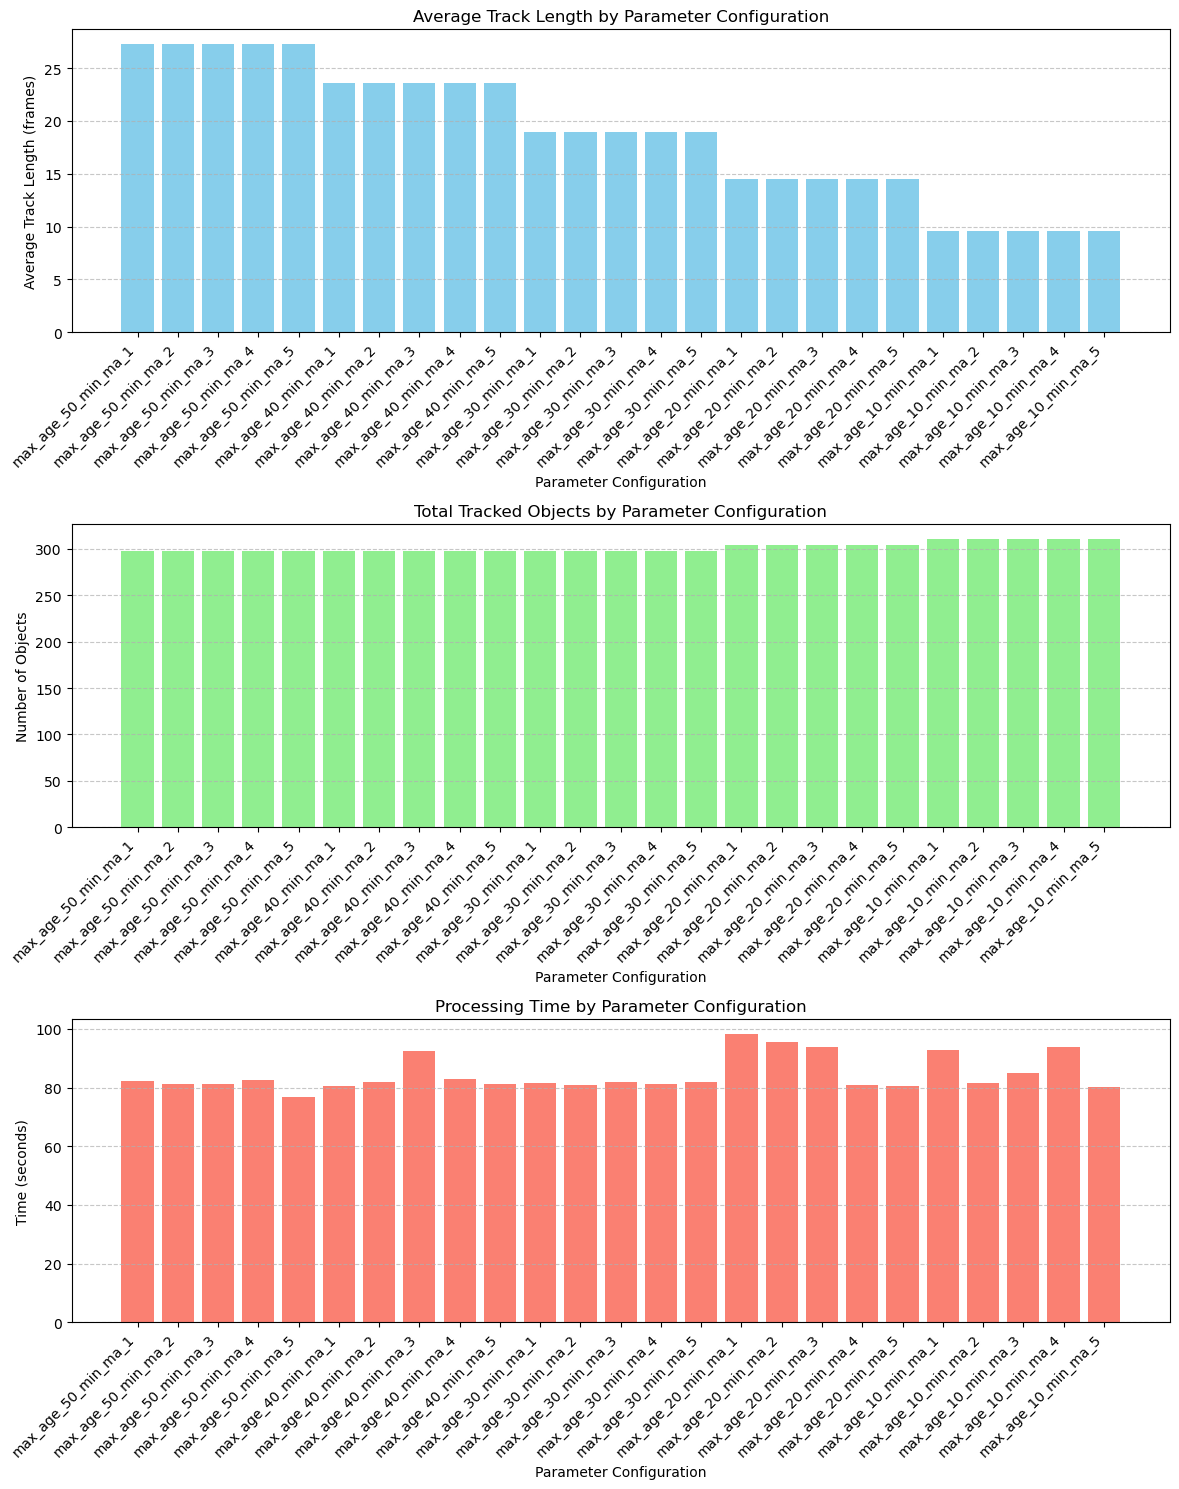

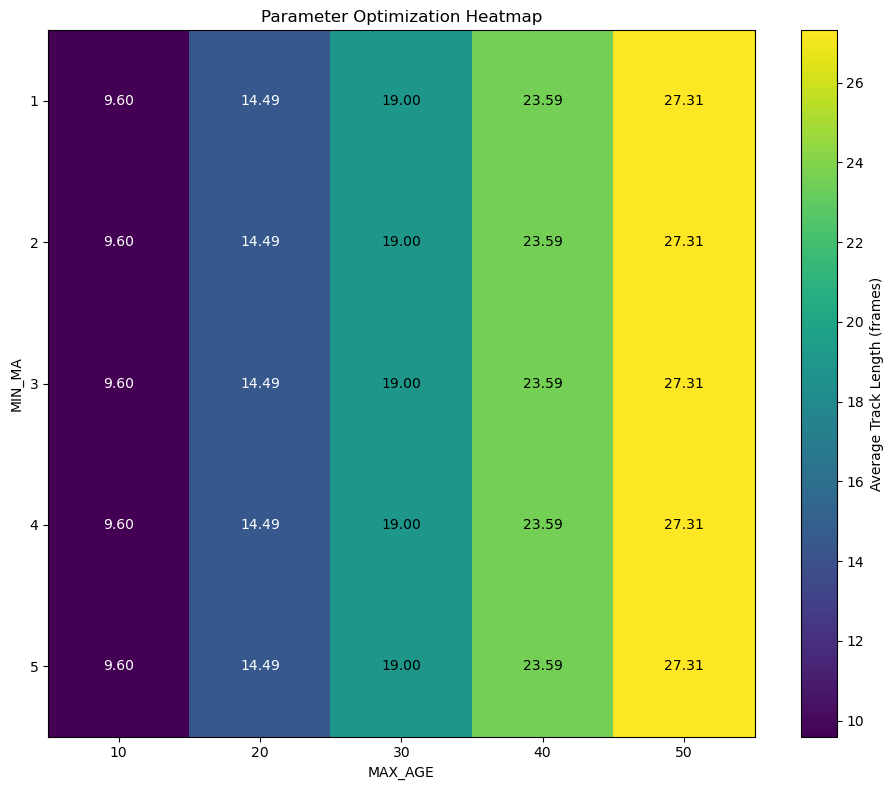


Updated config file generated at: C:\Users\DELL\Desktop\ctrlS nagpur\gpu-debug-main\test2out.MP4\updated_config.py
Replace your current config.py with this file to use the optimized parameters.


In [12]:
import asyncio

# Specify your video path here
video_path = "C:/Users/DELL/Desktop/ctrlS nagpur/gpu-debug-main/test2.MP4"  # Replace with your actual video path
output_dir = "C:/Users/DELL/Desktop/ctrlS nagpur/gpu-debug-main/test2out.MP4"  # Optional: change the output directory

# Run the tracking parameter debugger
best_max_age, best_min_ma = await run_debugger(video_path, output_dir)

In [17]:
import cv2
import numpy as np
import os
import json
from pathlib import Path
from datetime import datetime
import asyncio
import sys
import time
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from collections import defaultdict

# Import tracking components
from kalman_track import Sort
from model_manager import SingleGPUModelManager
from logger import setup_logger

logger = setup_logger('debug_tracker', 'debug_tracker.log')

class EnhancedTrackerDebugger:
    def __init__(self, video_path, output_dir="enhanced_debug", conf_threshold=0.6, show_display=True, max_frames=None):
        """Initialize the enhanced tracker debugger with post-processing capabilities"""
        self.video_path = video_path
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True, parents=True)
        self.conf_threshold = conf_threshold
        self.show_display = show_display
        self.max_frames = max_frames
        
        # Create subfolder for frame images
        self.frames_dir = self.output_dir / "frames"
        self.frames_dir.mkdir(exist_ok=True)
        
        # Initialize model manager with 1 instance
        self.model_manager = SingleGPUModelManager(instances_per_type=1)
        
        # Parameters to test - you can adjust these ranges
        self.max_age_values = [30, 40, 50]
        self.min_ma_values = [1, 3, 5]
        
        # Post-processing parameters
        self.min_track_length = 5  # Minimum frames a track must exist to be considered valid
        self.spatial_threshold = 50  # Pixels - max distance for track merging
        self.temporal_threshold = 20  # Frames - max time gap for track merging
        
        # Tracking results
        self.results = {}
        
        # Display window settings
        self.display_scale = 0.75
        
    async def get_model_instance(self):
        """Get an available model instance"""
        return await self.model_manager.get_available_model('hotspot')
        
    async def release_model_instance(self, instance):
        """Release the model instance"""
        await self.model_manager.release_model(instance)
        
    async def process_frame(self, frame, model_instance):
        """Process a single frame with the model"""
        results = model_instance.model(frame, conf=self.conf_threshold)
        
        # Get detections
        detections = []
        
        for r in results:
            boxes_tensor = r.boxes.xyxy.cpu()
            confs = r.boxes.conf.cpu()
            cls = r.boxes.cls.cpu()
            
            for box, conf, cl in zip(boxes_tensor, confs, cls):
                if conf >= self.conf_threshold:
                    x1, y1, x2, y2 = map(int, box[:4])
                    cx = (x1 + x2) / 2.
                    cy = (y1 + y2) / 2.
                    ar = (x2 - x1) / (y2 - y1)
                    h = (y2 - y1)
                    
                    # Additional size filtering to reduce small false positives
                    min_size = 10  # Minimum height in pixels
                    if h >= min_size:
                        detections.append({
                            'bbox': [cx, cy, ar, h],
                            'confidence': float(conf),
                            'class': int(cl)
                        })
        
        return results, detections
        
    def visualize_tracks(self, frame, tracked_objects, max_age, min_ma, filtered=False):
        """Visualize tracking results on frame"""
        annotated_frame = frame.copy()
        
        # Draw bounding boxes and IDs for each tracked object
        for class_id, objects in tracked_objects.items():
            color = self.get_color_for_class(class_id)
            
            for obj_id, obj_data in objects.items():
                # Skip objects that don't meet criteria if filtered mode is on
                if filtered and obj_data.get('filtered_out', False):
                    continue
                    
                centroid = obj_data['last_position']
                frames_tracked = obj_data['frames_tracked']
                
                # Adjust color intensity based on track length
                color_intensity = min(255, int(128 + frames_tracked * 2))
                track_color = list(color)
                for i in range(3):
                    if color[i] > 0:
                        track_color[i] = color_intensity
                track_color = tuple(track_color)
                
                # Draw circle at centroid
                cv2.circle(annotated_frame, centroid, 4, track_color, -1)
                
                # Draw ID and class
                label = f"C{class_id}-ID{obj_id} ({frames_tracked})"
                if 'merged_ids' in obj_data:
                    label = f"C{class_id}-ID{obj_id}* ({frames_tracked})"
                
                text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
                
                # Calculate text position
                text_x = centroid[0] - text_size[0] // 2
                text_y = centroid[1] - 10
                
                # Ensure text is within frame bounds
                text_x = max(5, min(text_x, frame.shape[1] - text_size[0] - 5))
                text_y = max(text_size[1] + 5, text_y)
                
                # Add background rectangle for text
                cv2.rectangle(
                    annotated_frame, 
                    (text_x - 2, text_y - text_size[1] - 2),
                    (text_x + text_size[0] + 2, text_y + 2),
                    (0, 0, 0), 
                    -1
                )
                
                # Draw text
                cv2.putText(
                    annotated_frame, 
                    label, 
                    (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, track_color, 2
                )
        
        # Add parameter info to frame
        cv2.rectangle(
            annotated_frame,
            (5, 5),
            (300, 100),
            (0, 0, 0),
            -1
        )
        
        cv2.putText(
            annotated_frame,
            f"MAX_AGE: {max_age}, MIN_MA: {min_ma}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2
        )
        
        mode_str = "FILTERED" if filtered else "ALL TRACKS"
        cv2.putText(
            annotated_frame,
            f"Mode: {mode_str}",
            (10, 60),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2
        )
        
        # Count tracks by class
        if filtered:
            valid_tracks = {
                cls: len([obj for obj in objs.values() if not obj.get('filtered_out', False)])
                for cls, objs in tracked_objects.items()
            }
            total_valid = sum(valid_tracks.values())
            cv2.putText(
                annotated_frame,
                f"Valid Tracks: {total_valid}",
                (10, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2
            )
        
        return annotated_frame
    
    def get_color_for_class(self, class_id):
        """Get a distinct color for each class"""
        colors = [
            (0, 255, 0),    # Green for class 0
            (255, 0, 0),    # Blue for class 1
            (0, 0, 255),    # Red for class 2
            (255, 255, 0),  # Cyan for class 3
        ]
        return colors[class_id % len(colors)]
    
    def display_frame(self, frame, title="Tracking Output"):
        """Display a frame in a window"""
        # Resize for display
        h, w = frame.shape[:2]
        display_w = int(w * self.display_scale)
        display_h = int(h * self.display_scale)
        display_frame = cv2.resize(frame, (display_w, display_h))
        
        # Convert BGR to RGB for matplotlib
        display_frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        
        # Clear previous output
        clear_output(wait=True)
        
        # Display using matplotlib
        plt.figure(figsize=(12, 8))
        plt.imshow(display_frame_rgb)
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Small delay to allow for display
        time.sleep(0.01)
    
    def save_frame_image(self, frame, max_age, min_ma, frame_num, filtered=False):
        """Save frame as an image file"""
        mode_str = "filtered" if filtered else "all"
        filename = f"frame_{max_age}_{min_ma}_{mode_str}_{frame_num:06d}.jpg"
        cv2.imwrite(str(self.frames_dir / filename), frame)
    
    def post_process_tracks(self, tracked_objects):
        """
        Post-process tracks to filter out noise and merge fragmented tracks
        
        Args:
            tracked_objects: Dict of tracked objects by class
            
        Returns:
            Filtered and merged tracked objects
        """
        processed_objects = {cls: {} for cls in tracked_objects.keys()}
        
        # First pass: copy tracks and mark short tracks as filtered
        for class_id, objects in tracked_objects.items():
            for obj_id, obj_data in objects.items():
                # Copy object data
                processed_objects[class_id][obj_id] = obj_data.copy()
                
                # Mark short tracks as filtered
                if obj_data['frames_tracked'] < self.min_track_length:
                    processed_objects[class_id][obj_id]['filtered_out'] = True
        
        # Second pass: try to merge fragmented tracks
        for class_id in processed_objects.keys():
            # Skip if no objects in this class
            if not processed_objects[class_id]:
                continue
                
            # Build track history with timestamps
            track_history = {}
            for obj_id, obj_data in processed_objects[class_id].items():
                if 'track_history' in obj_data:
                    track_history[obj_id] = obj_data['track_history']
            
            # Find merge candidates (tracks that are close in space and time)
            merged_ids = set()
            
            # Sort tracks by ID for deterministic merging
            sorted_ids = sorted(processed_objects[class_id].keys())
            
            for i, obj_id1 in enumerate(sorted_ids):
                # Skip if already merged
                if obj_id1 in merged_ids:
                    continue
                    
                obj1 = processed_objects[class_id][obj_id1]
                
                # Skip filtered objects as merge targets
                if obj1.get('filtered_out', False):
                    continue
                
                # Initialize merged IDs list if not already there
                if 'merged_ids' not in obj1:
                    obj1['merged_ids'] = []
                
                for j, obj_id2 in enumerate(sorted_ids[i+1:], i+1):
                    # Skip if already merged
                    if obj_id2 in merged_ids:
                        continue
                        
                    obj2 = processed_objects[class_id][obj_id2]
                    
                    # Check if tracks are candidates for merging
                    can_merge = self.check_merge_candidates(obj1, obj2)
                    
                    if can_merge:
                        # Merge tracks
                        obj1['frames_tracked'] += obj2['frames_tracked']
                        obj1['merged_ids'].append(obj_id2)
                        merged_ids.add(obj_id2)
                        
                        # Mark the second object as merged
                        obj2['filtered_out'] = True
                        obj2['merged_into'] = obj_id1
        
        # Count valid (non-filtered) objects
        valid_count = {
            cls: len([obj for obj in objs.values() if not obj.get('filtered_out', False)])
            for cls, objs in processed_objects.items()
        }
        
        return processed_objects, valid_count
    
    def check_merge_candidates(self, obj1, obj2):
        """
        Check if two tracks are candidates for merging
        
        Args:
            obj1: First track
            obj2: Second track
            
        Returns:
            bool: True if tracks can be merged
        """
        # Don't merge if either object is filtered out
        if obj1.get('filtered_out', False) or obj2.get('filtered_out', False):
            return False
        
        # Check spatial proximity of last known positions
        pos1 = obj1['last_position']
        pos2 = obj2['last_position']
        
        # Calculate Euclidean distance
        distance = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
        
        # Check if distance is within threshold
        if distance > self.spatial_threshold:
            return False
        
        # For enhanced checks, we would need track history with timestamps
        # This is a simplified check based only on the last position
        return True
        
    async def test_parameters(self):
        """Test different combinations of tracking parameters with post-processing"""
        cap = cv2.VideoCapture(self.video_path)
        if not cap.isOpened():
            raise Exception(f"Failed to open video: {self.video_path}")
            
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        logger.info(f"Processing video with {total_frames} frames at {fps} FPS, resolution: {width}x{height}")
        print(f"Processing video with {total_frames} frames at {fps} FPS, resolution: {width}x{height}")
        print(f"Using confidence threshold: {self.conf_threshold}")
        
        # Limit total frames if requested
        if self.max_frames and self.max_frames < total_frames:
            total_frames = self.max_frames
            print(f"Limiting processing to {total_frames} frames")
        
        # Get model instance
        model_instance = await self.get_model_instance()
        
        try:
            # Test each parameter combination
            for max_age in self.max_age_values:
                for min_ma in self.min_ma_values:
                    param_key = f"max_age_{max_age}_min_ma_{min_ma}"
                    output_video_path = self.output_dir / f"{param_key}_all.mp4"
                    filtered_video_path = self.output_dir / f"{param_key}_filtered.mp4"
                    
                    logger.info(f"Testing MAX_AGE={max_age}, MIN_MA={min_ma}")
                    print(f"Testing MAX_AGE={max_age}, MIN_MA={min_ma}")
                    
                    # Initialize trackers for each class
                    trackers = {}
                    for class_id in range(4):
                        trackers[class_id] = Sort(max_age=max_age, min_ma=min_ma)
                    
                    # Reset video
                    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                    
                    # Setup video writers
                    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                    writer_all = cv2.VideoWriter(
                        str(output_video_path), 
                        fourcc, 
                        fps, 
                        (width, height)
                    )
                    
                    writer_filtered = cv2.VideoWriter(
                        str(filtered_video_path), 
                        fourcc, 
                        fps, 
                        (width, height)
                    )
                    
                    # Process all frames
                    frame_count = 0
                    tracked_objects = {class_id: {} for class_id in range(4)}
                    processing_start = datetime.now()
                    
                    # Track history for each object
                    track_history = {class_id: {} for class_id in range(4)}
                    
                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break
                            
                        frame_count += 1
                        
                        # Stop if we've reached max_frames
                        if self.max_frames and frame_count > self.max_frames:
                            break
                        
                        # Process every 5th frame for speed
                        # Adjust this sampling rate as needed
                        if frame_count % 5 == 0:
                            # Process frame
                            results, detections = await self.process_frame(frame, model_instance)
                            
                            # Organize detections by class
                            class_detections = {class_id: [] for class_id in range(4)}
                            for det in detections:
                                class_id = det['class']
                                bbox = det['bbox']
                                class_detections[class_id].append(bbox)
                                
                            # Update trackers for each class
                            for class_id, dets in class_detections.items():
                                if len(dets) > 0:
                                    dets_array = np.array(dets)
                                    tracked_bbox, count = trackers[class_id].update(dets_array)
                                else:
                                    tracked_bbox, count = trackers[class_id].update()
                                    
                                # Update tracked objects for this class
                                if len(tracked_bbox) > 0:
                                    for track in tracked_bbox:
                                        object_id = int(track[-1])
                                        centroid = (int(track[0]), int(track[1]))
                                        
                                        if object_id not in tracked_objects[class_id]:
                                            tracked_objects[class_id][object_id] = {
                                                'frames_tracked': 0,
                                                'last_position': centroid,
                                                'class_id': class_id,
                                                'track_history': []
                                            }
                                        
                                        tracked_objects[class_id][object_id]['frames_tracked'] += 1
                                        tracked_objects[class_id][object_id]['last_position'] = centroid
                                        
                                        # Add to track history
                                        tracked_objects[class_id][object_id]['track_history'].append({
                                            'frame': frame_count,
                                            'position': centroid
                                        })
                            
                            # Post-process tracks to filter out noise and merge fragmented tracks
                            filtered_objects, valid_counts = self.post_process_tracks(tracked_objects)
                            
                            # Draw all tracks
                            annotated_frame_all = self.visualize_tracks(
                                frame, tracked_objects, max_age, min_ma, filtered=False
                            )
                            
                            # Draw filtered tracks
                            annotated_frame_filtered = self.visualize_tracks(
                                frame, filtered_objects, max_age, min_ma, filtered=True
                            )
                            
                            # Display frames if requested
                            if self.show_display and frame_count % 10 == 0:
                                title = (f"Tracking with MAX_AGE={max_age}, MIN_MA={min_ma} | "
                                        f"Frame {frame_count}/{total_frames}")
                                # Show both views side by side
                                combined = np.hstack((
                                    cv2.resize(annotated_frame_all, (width//2, height//2)),
                                    cv2.resize(annotated_frame_filtered, (width//2, height//2))
                                ))
                                self.display_frame(combined, title)
                            
                            # Save key frames as individual images
                            if frame_count % 30 == 0:
                                self.save_frame_image(
                                    annotated_frame_all, max_age, min_ma, frame_count, filtered=False
                                )
                                self.save_frame_image(
                                    annotated_frame_filtered, max_age, min_ma, frame_count, filtered=True
                                )
                            
                            # Write frames to videos
                            writer_all.write(annotated_frame_all)
                            writer_filtered.write(annotated_frame_filtered)
                            
                            # Display progress
                            if frame_count % 100 == 0:
                                logger.info(f"Processed {frame_count}/{total_frames} frames")
                                if not self.show_display:
                                    print(f"Processed {frame_count}/{total_frames} frames")
                                    print(f"Valid tracks after filtering: {sum(valid_counts.values())}")
                        else:
                            # Write original frame to both videos to maintain timing
                            writer_all.write(frame)
                            writer_filtered.write(frame)
                    
                    writer_all.release()
                    writer_filtered.release()
                    
                    # Calculate metrics
                    processing_time = (datetime.now() - processing_start).total_seconds()
                    
                    # Post-process final tracks
                    final_filtered_objects, final_valid_counts = self.post_process_tracks(tracked_objects)
                    
                    total_tracked_objects = sum(len(objs) for objs in tracked_objects.values())
                    total_valid_objects = sum(final_valid_counts.values())
                    
                    # Track stability metrics
                    avg_track_length = 0
                    if total_tracked_objects > 0:
                        total_frames_tracked = sum(
                            obj['frames_tracked'] 
                            for class_objs in tracked_objects.values() 
                            for obj in class_objs.values()
                        )
                        avg_track_length = total_frames_tracked / total_tracked_objects
                    
                    # Average track length for valid tracks
                    avg_valid_track_length = 0
                    total_valid_frames = 0
                    valid_count = 0
                    
                    for class_id, objects in final_filtered_objects.items():
                        for obj_id, obj_data in objects.items():
                            if not obj_data.get('filtered_out', False):
                                total_valid_frames += obj_data['frames_tracked']
                                valid_count += 1
                    
                    if valid_count > 0:
                        avg_valid_track_length = total_valid_frames / valid_count
                    
                    self.results[param_key] = {
                        'max_age': max_age,
                        'min_ma': min_ma,
                        'total_frames': frame_count,
                        'total_tracked_objects': total_tracked_objects,
                        'avg_track_length': avg_track_length,
                        'filtered_objects': total_valid_objects,
                        'avg_valid_track_length': avg_valid_track_length,
                        'processing_time': processing_time,
                        'objects_per_class_raw': {
                            str(class_id): len(objs) 
                            for class_id, objs in tracked_objects.items()
                        },
                        'objects_per_class_filtered': {
                            str(class_id): count
                            for class_id, count in final_valid_counts.items()
                        }
                    }
            
            # Save results to JSON
            with open(self.output_dir / 'tracking_results.json', 'w') as f:
                json.dump(self.results, f, indent=2)
                
            # Find best parameters based on filtered track quality
            best_params = max(self.results.items(), key=lambda x: x[1]['avg_valid_track_length'])
            best_key, best_metrics = best_params
            
            logger.info(f"Best parameters: {best_key}")
            logger.info(f"Filtered objects: {best_metrics['filtered_objects']}")
            print(f"Best parameters: {best_key}")
            print(f"Filtered objects: {best_metrics['filtered_objects']}")
            
            return best_metrics
                
        finally:
            cap.release()
            # Release model instance
            await self.release_model_instance(model_instance)
            
    def analyze_results(self, visualize=True):
        """Analyze and print tracking results with focus on filtered results"""
        if not self.results:
            logger.error("No results to analyze")
            print("No results to analyze")
            return
            
        # Sort by average filtered track length (higher is better)
        sorted_results = sorted(
            self.results.items(), 
            key=lambda x: x[1]['avg_valid_track_length'], 
            reverse=True
        )
        
        print("\n========== TRACKING PARAMETER RESULTS (FILTERED) ==========")
        print(f"{'Parameters':<20} {'Valid Objects':<15} {'Avg Valid Length':<20} {'Processing Time':<15}")
        print("-" * 75)
        
        for key, metrics in sorted_results:
            print(f"{key:<20} {metrics['filtered_objects']:<15} {metrics['avg_valid_track_length']:<20.2f} {metrics['processing_time']:<15.2f}s")
            
        # Get the best parameters
        best_key, best_metrics = sorted_results[0]
        max_age = best_metrics['max_age']
        min_ma = best_metrics['min_ma']
        
        print("\n========== BEST PARAMETERS ==========")
        print(f"MAX_AGE: {max_age}")
        print(f"MIN_MA: {min_ma}")
        print(f"Confidence threshold: {self.conf_threshold}")
        print(f"Average valid track length: {best_metrics['avg_valid_track_length']:.2f} frames")
        print(f"Total raw tracked objects: {best_metrics['total_tracked_objects']}")
        print(f"Total filtered objects: {best_metrics['filtered_objects']}")
        print(f"Objects per class (raw): {best_metrics['objects_per_class_raw']}")
        print(f"Objects per class (filtered): {best_metrics['objects_per_class_filtered']}")
        
        # Visualize results if requested
        if visualize:
            self.visualize_results(sorted_results)
        
        # Update config suggestion
        config_path = Path("config.py")
        if config_path.exists():
            try:
                config_text = config_path.read_text()
                updated_config = config_text.replace(
                    f"MAX_AGE = 30", # Assuming default is 30
                    f"MAX_AGE = {max_age}"
                ).replace(
                    f"MIN_MA = 3", # Assuming default is 3
                    f"MIN_MA = {min_ma}"
                )
                
                # Also suggest adding threshold for defect tracking
                if "TRACKING_THRESHOLD" in config_text:
                    updated_config = updated_config.replace(
                        f"TRACKING_THRESHOLD = 5",  # Assuming default is 5
                        f"TRACKING_THRESHOLD = {self.conf_threshold*10:.0f}"  # Scale to similar range
                    )
                
                # Add min track length parameter
                if "MIN_TRACK_LENGTH" not in config_text:
                    lines = updated_config.split('\n')
                    min_ma_line_idx = -1
                    for i, line in enumerate(lines):
                        if "MIN_MA = " in line:
                            min_ma_line_idx = i
                            break
                    
                    if min_ma_line_idx >= 0:
                        lines.insert(min_ma_line_idx + 1, f"MIN_TRACK_LENGTH = {self.min_track_length}  # Minimum frames to consider a track valid")
                        updated_config = '\n'.join(lines)
                
                update_path = Path(self.output_dir) / "updated_config.py"
                update_path.write_text(updated_config)
                
                print(f"\nUpdated config file generated at: {update_path}")
                print("Replace your current config.py with this file to use the optimized parameters.")
            except Exception as e:
                print(f"Error updating config: {e}")
        
        return max_age, min_ma, self.conf_threshold
    
    def visualize_results(self, sorted_results):
        # Extract data for plotting
        params = [key for key, _ in sorted_results]
        raw_object_counts = [metrics['total_tracked_objects'] for _, metrics in sorted_results]
        filtered_object_counts = [metrics['filtered_objects'] for _, metrics in sorted_results]
        avg_track_lengths = [metrics['avg_track_length'] for _, metrics in sorted_results]
        avg_valid_track_lengths = [metrics['avg_valid_track_length'] for _, metrics in sorted_results]
        
        # Create figure with multiple subplots
        fig, axs = plt.subplots(2, 1, figsize=(12, 12))
        
        # Plot object counts
        x_positions = np.arange(len(params))
        width = 0.35
        
        axs[0].bar(
            x_positions - width/2, 
            raw_object_counts, 
            width,
            color='lightblue', 
            alpha=0.7,
            label='Raw Tracks'
        )
        axs[0].bar(
            x_positions + width/2, 
            filtered_object_counts, 
            width,
            color='darkblue',
            label='Filtered Tracks'
        )
        axs[0].set_title('Object Count Comparison')
        axs[0].set_xlabel('Parameter Configuration')
        axs[0].set_ylabel('Number of Objects')
        axs[0].set_xticks(x_positions)
        axs[0].set_xticklabels(params, rotation=45, ha='right')
        axs[0].grid(axis='y', linestyle='--', alpha=0.7)
        axs[0].legend()
        
        # Plot track lengths
        axs[1].bar(
            x_positions - width/2, 
            avg_track_lengths, 
            width,
            color='lightgreen', 
            alpha=0.7,
            label='Raw Track Length'
        )
        axs[1].bar(
            x_positions + width/2, 
            avg_valid_track_lengths, 
            width,
            color='darkgreen',
            label='Filtered Track Length'
        )
        axs[1].set_title('Average Track Length Comparison')
        axs[1].set_xlabel('Parameter Configuration')
        axs[1].set_ylabel('Average Track Length (frames)')
        axs[1].set_xticks(x_positions)
        axs[1].set_xticklabels(params, rotation=45, ha='right')
        axs[1].grid(axis='y', linestyle='--', alpha=0.7)
        axs[1].legend()
        
        plt.tight_layout()
        
        # Save figure
        fig.savefig(str(self.output_dir / 'parameter_comparison.png'), dpi=300, bbox_inches='tight')
        
        # Display figure
        plt.show()

        # Create parameter heatmap for MAX_AGE and MIN_MA if multiple values tested
        if len(self.max_age_values) > 1 and len(self.min_ma_values) > 1:
            # Create matrices for heatmaps
            heatmap_objects = np.zeros((len(self.min_ma_values), len(self.max_age_values)))
            heatmap_track_length = np.zeros((len(self.min_ma_values), len(self.max_age_values)))
            
            for i, min_ma in enumerate(self.min_ma_values):
                for j, max_age in enumerate(self.max_age_values):
                    key = f"max_age_{max_age}_min_ma_{min_ma}"
                    if key in self.results:
                        heatmap_objects[i, j] = self.results[key]['filtered_objects']
                        heatmap_track_length[i, j] = self.results[key]['avg_valid_track_length']
            
            # Plot object count heatmap
            plt.figure(figsize=(10, 8))
            plt.imshow(heatmap_objects, cmap='viridis', interpolation='nearest')
            plt.colorbar(label='Filtered Object Count')
            plt.title('Filtered Object Count by Parameter Combination')
            plt.xlabel('MAX_AGE')
            plt.ylabel('MIN_MA')
            plt.xticks(range(len(self.max_age_values)), self.max_age_values)
            plt.yticks(range(len(self.min_ma_values)), self.min_ma_values)
            
            # Add text annotations in each cell
            for i in range(len(self.min_ma_values)):
                for j in range(len(self.max_age_values)):
                    plt.text(j, i, f"{heatmap_objects[i, j]:.0f}", 
                        ha="center", va="center", 
                        color="w" if heatmap_objects[i, j] < np.max(heatmap_objects)/1.5 else "black")
            
            plt.tight_layout()
            plt.savefig(str(self.output_dir / 'object_count_heatmap.png'), dpi=300, bbox_inches='tight')
            plt.show()
            
            # Plot track length heatmap
            plt.figure(figsize=(10, 8))
            plt.imshow(heatmap_track_length, cmap='plasma', interpolation='nearest')
            plt.colorbar(label='Avg Track Length (frames)')
            plt.title('Average Track Length by Parameter Combination')
            plt.xlabel('MAX_AGE')
            plt.ylabel('MIN_MA')
            plt.xticks(range(len(self.max_age_values)), self.max_age_values)
            plt.yticks(range(len(self.min_ma_values)), self.min_ma_values)
            
            # Add text annotations in each cell
            for i in range(len(self.min_ma_values)):
                for j in range(len(self.max_age_values)):
                    plt.text(j, i, f"{heatmap_track_length[i, j]:.1f}", 
                        ha="center", va="center", 
                        color="w" if heatmap_track_length[i, j] < np.max(heatmap_track_length)/1.5 else "black")
            
            plt.tight_layout()
            plt.savefig(str(self.output_dir / 'track_length_heatmap.png'), dpi=300, bbox_inches='tight')
            plt.show()

        # Plot class distribution
        best_key = sorted_results[0][0]
        best_metrics = sorted_results[0][1]
        
        # Raw class distribution
        raw_classes = best_metrics['objects_per_class_raw']
        filtered_classes = best_metrics['objects_per_class_filtered']
        
        class_labels = [f'Class {i}' for i in range(len(raw_classes))]
        
        # Class distribution plot
        plt.figure(figsize=(10, 6))
        x_pos = np.arange(len(class_labels))
        width = 0.35
        
        raw_values = [raw_classes.get(str(i), 0) for i in range(len(class_labels))]
        filtered_values = [filtered_classes.get(str(i), 0) for i in range(len(class_labels))]
        
        plt.bar(x_pos - width/2, raw_values, width, label='Raw', color='skyblue')
        plt.bar(x_pos + width/2, filtered_values, width, label='Filtered', color='navy')
        
        plt.xlabel('Object Class')
        plt.ylabel('Number of Objects')
        plt.title(f'Object Class Distribution for {best_key}')
        plt.xticks(x_pos, class_labels)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(str(self.output_dir / 'class_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()

    # Function to run from Jupyter notebook
    async def run_enhanced_debugger(
        video_path, 
        output_dir="enhanced_debug", 
        show_display=True, 
        max_frames=None,
        conf_threshold=0.6
    ):
        """
        Run the enhanced tracking parameter debugger with post-processing
        
        Args:
            video_path (str): Path to the video file
            output_dir (str): Directory to save outputs
            show_display (bool): Whether to show live visualization
            max_frames (int, optional): Maximum number of frames to process
            conf_threshold (float): Detection confidence threshold
            
        Returns:
            tuple: Best MAX_AGE, MIN_MA and confidence threshold values
        """
        debugger = EnhancedTrackerDebugger(
            video_path=video_path, 
            output_dir=output_dir,
            show_display=show_display,
            max_frames=max_frames,
            conf_threshold=conf_threshold
        )
        
        await debugger.test_parameters()
        max_age, min_ma, conf = debugger.analyze_results()
        
        return max_age, min_ma, conf

    # Example usage in notebook:
    # video_path = "path/to/your/video.mp4"
    # best_max_age, best_min_ma, best_conf = await run_enhanced_debugger(
    #     video_path, 
    #     max_frames=1000, 
    #     conf_threshold=0.6
    # )
            

In [19]:
# Function to run from Jupyter notebook
async def run_enhanced_debugger(
    video_path, 
    output_dir="enhanced_debug", 
    show_display=True, 
    max_frames=None,
    conf_threshold=0.6
):
    """
    Run the enhanced tracking parameter debugger with post-processing
    
    Args:
        video_path (str): Path to the video file
        output_dir (str): Directory to save outputs
        show_display (bool): Whether to show live visualization
        max_frames (int, optional): Maximum number of frames to process
        conf_threshold (float): Detection confidence threshold
        
    Returns:
        tuple: Best MAX_AGE, MIN_MA and confidence threshold values
    """
    debugger = EnhancedTrackerDebugger(
        video_path=video_path, 
        output_dir=output_dir,
        show_display=show_display,
        max_frames=max_frames,
        conf_threshold=conf_threshold
    )
    
    await debugger.test_parameters()
    max_age, min_ma, conf = debugger.analyze_results()
    
    return max_age, min_ma, conf

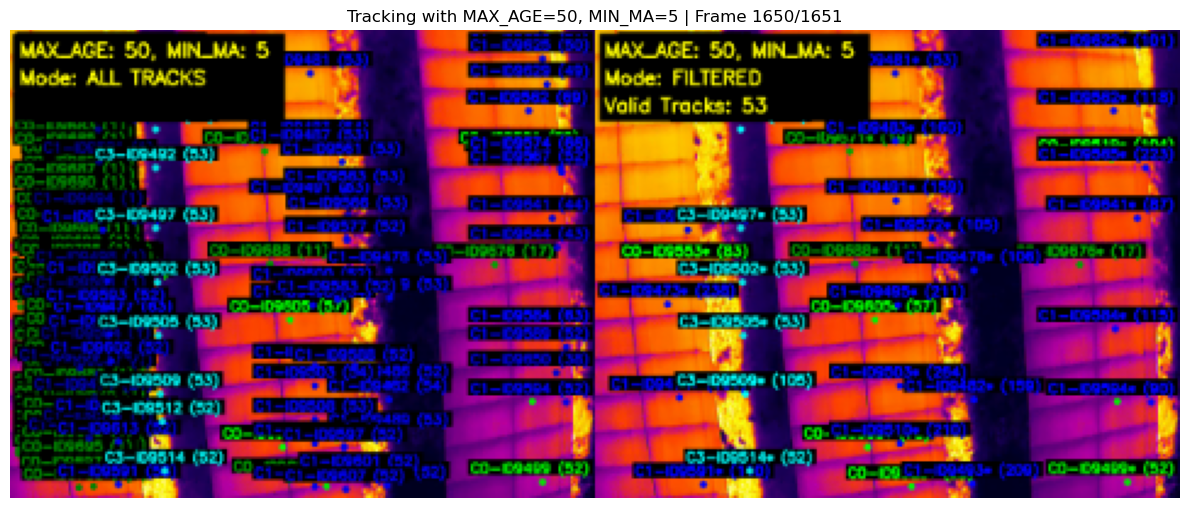

2025-03-03 20:35:01,410 - debug_tracker - INFO - Best parameters: max_age_50_min_ma_1
2025-03-03 20:35:01,411 - debug_tracker - INFO - Filtered objects: 53
Best parameters: max_age_50_min_ma_1
Filtered objects: 53
2025-03-03 20:35:01,416 - gpu_model_manager - INFO - Released hotspot model instance

========== TRACKING PARAMETER RESULTS (FILTERED) ==========
Parameters           Valid Objects   Avg Valid Length     Processing Time
---------------------------------------------------------------------------
max_age_50_min_ma_1  53              112.87               73.08          s
max_age_50_min_ma_3  53              112.87               73.34          s
max_age_50_min_ma_5  53              112.87               73.95          s
max_age_40_min_ma_1  52              98.48                67.11          s
max_age_40_min_ma_3  52              98.48                68.68          s
max_age_40_min_ma_5  52              98.48                71.49          s
max_age_30_min_ma_1  51              81.

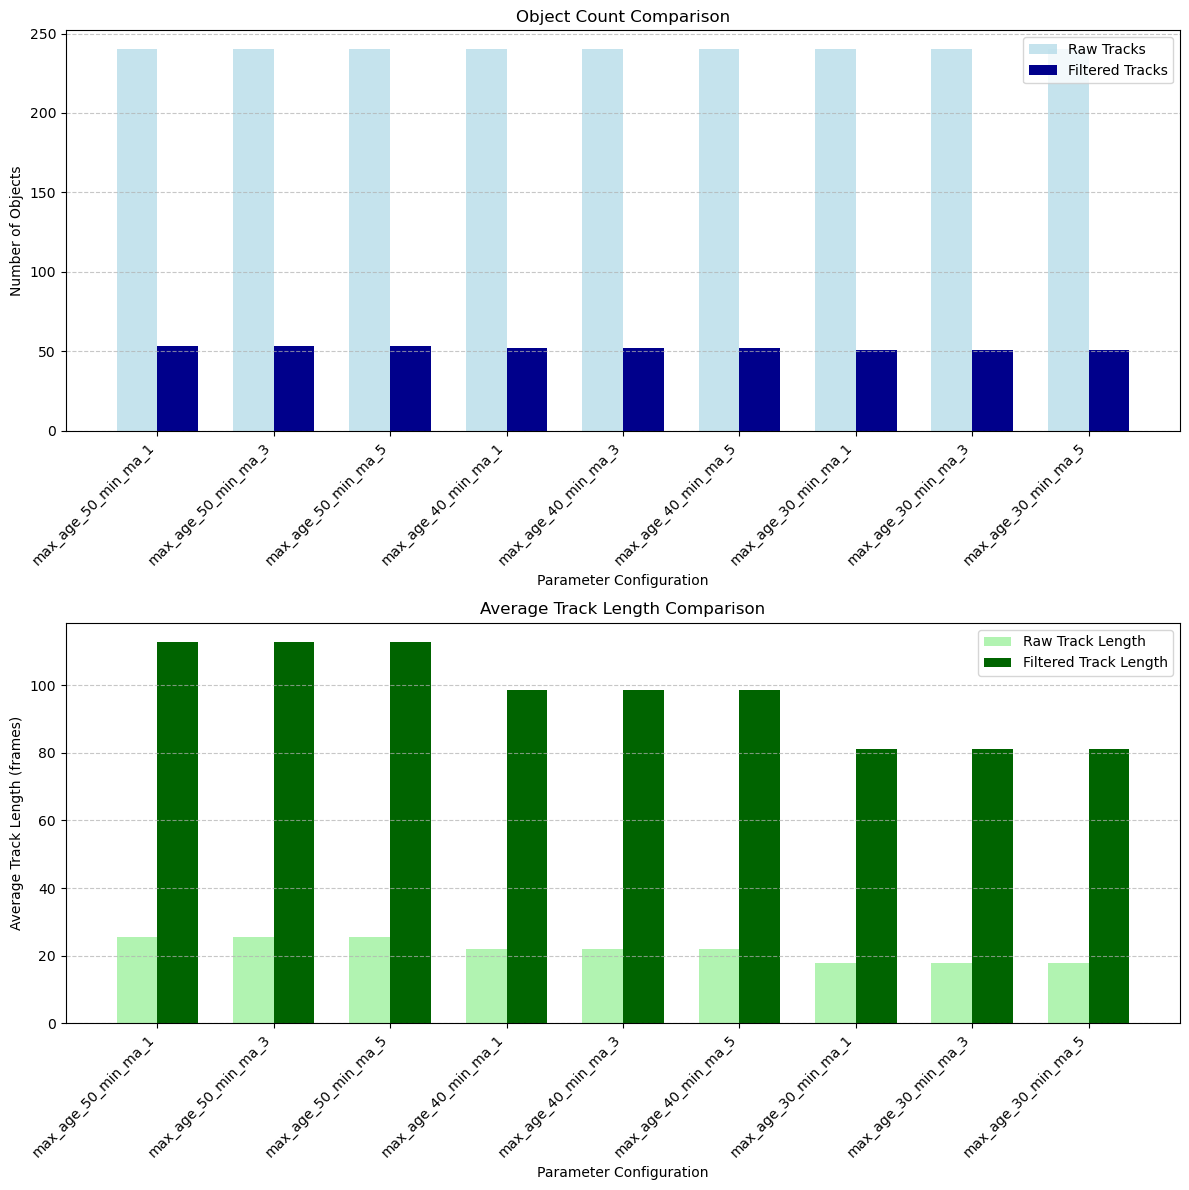

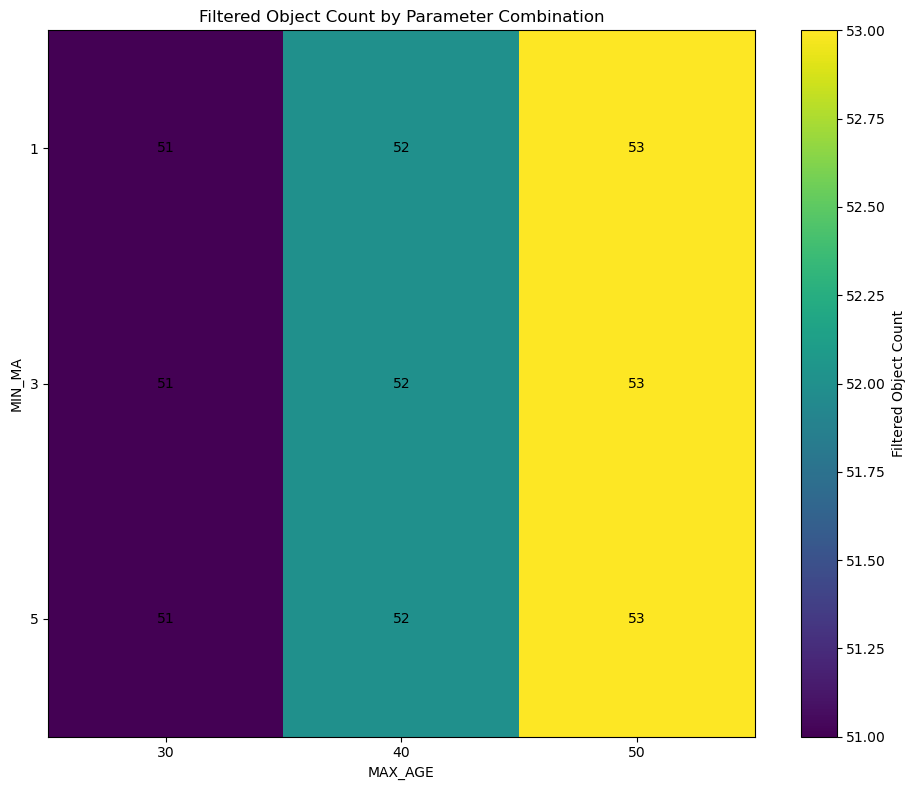

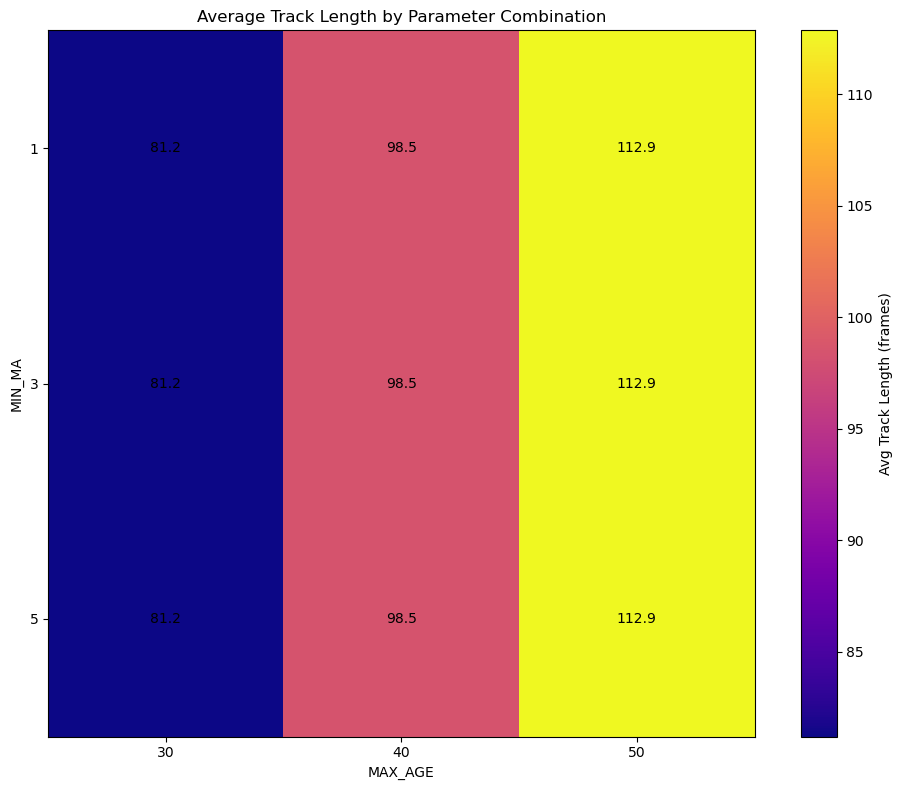

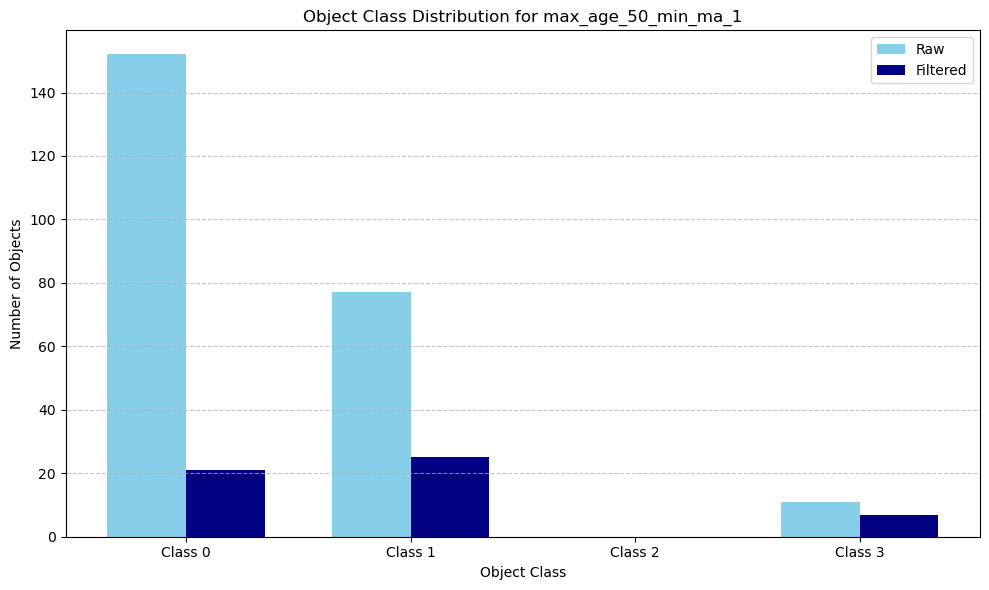


Updated config file generated at: test2_debug_results\updated_config.py
Replace your current config.py with this file to use the optimized parameters.

Final recommended parameters:
MAX_AGE = 50
MIN_MA = 1
Confidence threshold = 0.6


In [20]:
# Specify your video path
video_path = "C:/Users/DELL/Desktop/ctrlS nagpur/gpu-debug-main/test2.MP4"

# Run the enhanced debugger
import asyncio
best_max_age, best_min_ma, best_conf = await run_enhanced_debugger(
    video_path=video_path,
    output_dir="test2_debug_results",
    show_display=True,  # Set to True to see the live tracking display
    max_frames=None,    # Process all frames (set a number like 1000 for faster testing)
    conf_threshold=0.6  # Higher confidence threshold to reduce false positives
)

print(f"\nFinal recommended parameters:")
print(f"MAX_AGE = {best_max_age}")
print(f"MIN_MA = {best_min_ma}")
print(f"Confidence threshold = {best_conf}")